# Initialschätzung von Kurswechselpositionen eines Segelboots auf einer Karte anhand von Wind, Start und Zielpunkt


**Semesterabschließende Arbeit - Machine Learning**

**Name: Philipp Horstenkamp**

**Matrikel-Nr.: 30247701**



## Motivation

Ziel dieser Semesterabschließenden schriftlichen Ausarbeitung im Fach "Machine Learning" an der Fachhochschule Südwestfalen ist das Generieren einer Heatmap von Kurswechselpositionen eines Segelbootes zu einer Karte abhängig von Wind und der Zielpostion. Dies soll das Finden einer guten Route vereinfachen, indem die Qualität der Initialen Route verbessert wird. Diese werden danach über ein Quotientenabstiegsverfahren optimiert. Da ein solches Quotientenabstiegsverfahren sehr gerne in einem lokalen Minimum festhängt, müssen mehrere Routen gefunden und optimiert werden. Hier soll untersucht werden, ob dies durch eine Ersteinschätzung der Lage durch KI verbessert werden kann.

Eingesetzt werden soll die so erstellte KI in dem Segelroboter des [Sailing Team Darmstadt e.V.](https://www.st-darmstadt.de/), einer Hochschulgruppe an der TU-Darmstadt, welche den ["roBOOTer"](https://www.st-darmstadt.de/ueber-uns/boote/prototyp-ii/) ein vollautonomes Segelboot, das eines Tages den Atlantik überqueren soll. [Eine technische Herausforderung, welche zuerst von einem norwegischen Team erfolgreich abgeschlossen wurde](https://www.microtransat.org/).

## Inhaltsverzeichnis

1. Einleitung

    1.1. Situation
    
    1.2. Vorgehen zur unterstützenden KI
        1.2.1. Eingaben und Ausgeben
2. Vorbereitungen

    2.1. Imports
    
    2.2. Parameter und Settings
    
3. Szenarien und Routen generieren

    3.1. Generieren von Karten
        3.2.1 Parameter zum Generieren der Karte

    3.2. Generieren des Zieles

    3.3. Das Normieren eines Szenarios

    3.4. Massengenerierung von Szenarios

    3.5. Daten zusammenfassen

4. Szenarios filtern

    4.1. Die Route verlässt die Karte

    4.2. Routen auf Fehler überprüfen

    4.3. Filtern der Routen nach Kosten

    4.4. Filtern der Routen nach Komplexität

5. Das Konvertieren in trainierbare Daten

6. Das Model

    6.1. Der Generator
        6.1.1 Model Erstellung
    6.2. Model Training
        6.2.1. Training des Modells mit Routen als Linien
        6.2.2. Betrachtung des trainierten Models mit Routen als Linien
        6.2.3. Training mit Routen als Liste von Wendepunkten
        6.2.4. Betrachtung des trainierten Models mit Routen als Liste von Wendepunkten


7. Vergleich der Experimente

9. Reflektion und Ausblick

10. Literaturverzeichnis


## Einleitung
### Situation
Eine Routenplanung für ein Segelboot hat ein Problem, welches man sonst so eher nicht kennt. Eine relativ freie Fläche auf der sich das Schiff bewegen kann. Dies verändert die Wegfindung wie man sie von der Straße kennt, fundamental.
Navigiert man auf Straßen, hat man zumindest nach einer ersten Abstraktion relativ wenige Freiheitsgrade für den Weg. Die Richtung kann nur an Kreuzungen gewechselt werden und dort nur in Richtungen, in die es Straßen gibt. Beim Segeln auf dem freien Meer ist jeder Ort ein potenzieller Wendepunkt, von dem aus potenziell in jede Richtung gesegelt werden kann.
Dennoch ist es auch ohne Hindernisse zwischen Boot und Ziel oft nicht möglich das Ziel direkt anzufahren, da sich die Maximalgeschwindigkeiten relativ zur Windrichtung verändern. Das folgende Diagramm zeigt die Segelgeschwindigkeiten an einem Katamaran.

Da der roBOOTer anders als ein Katamaran nicht auf Geschwindigkeit, sondern auf mechanische Belastbarkeit ausgelegt wurde hat der Fahrtwind einen geringeren Einfluss auf das Fahrtverhalten des Segelboots. Dies und eine andere Maximalgeschwindigkeit sorgen für ein etwas anderes Fahrverhalten. Die ungefähre Form der Kurven trifft aber auch auf den roBOOTer zu. Man kann deutlich erkennen, dass auch, wenn man nicht direkt gegen den Wind fahren kann man schräg gegen den Wind immer noch erstaunlich schnell ist.
Das aktuelle Verfahren zum Finden einer Route läuft folgendermaßen ab:
Eine direkte Route wird berechnet. Die Route wird an jedem Hindernisse geteilt und rechts und links um jedes Hindernis herum gelegt. Bei folgenden Hindernissen werden die Routen wieder geteilt somit erhält man Vorschläge für Routen, wobei die Anzahl der Hindernisse auf der Route ist. Jeder Abschnitt der Route wird noch einmal zerteilt, um der Route mehr Flexibilität zu geben.
Die Routen werden dann simuliert, um die Kosten der Route zu berechnen. Die so simulierte Route wird danach über die Kosten in einem Gradientenabstiegsverfahren optimiert.
Das ganze oben beschriebene Verfahren ist relativ schnell sehr rechenaufwendig und findet nicht immer ein Ergebnis. Wird kein Ergebnis gefunden wird eine mehr oder weniger zufällige Route optimiert.
Diese Ausarbeitung soll wenigstens bei der alternativen Routenfindung helfen. Im Idealfall kann es aber auch genutzt werden, um die Auswahl der Routen um Hindernisse frühzeitig zu reduzieren und den Rechenaufwand unter   zu senken wobei   die Anzahl von Hindernissen auf der Route ist.

### Vorgehen zur unterstützenden KI

#### Eingaben und Ausgeben

Die Algorithmen zur Wegfindung vom Sailing Team Darmstadt e.V. arbeiten intern mit Polygonen als Hindernissen. Diese werden durch die Shapely Bibliothek implementiert. Da eine variable Anzahl an Polygonen mit einer variablen Form und Position ein relativ komplexer Eingabewert ist, muss dieser in eine normierte Form gebracht werden. Ein binärfarbiges Bild ist dafür die einfachste Form.
Für den Computer spielen weder Zentrierung noch Skalierung und Ausrichtung der Karte eine Rolle. Wir rotieren also die Karte immer, so das der Wind von Norden kommt und das Boot / die Startposition in der Mitte der Karte liegt. Da Distanz ein linearer Faktor ist, wird davon ausgegangen, dass das Szenario einfach passend skaliert werden kann.
Die nächste Eingabe ist die Zielposition relativ zum Startpunkt. Diese kann entweder durch ein einzelnes Pixel in einem zweiten Farbkanal oder aber in abstrakterer Form an die KI übergeben werden.
Als Ausgabe wird eine Heatmap erwartet. Zwei alternative Heatmaps sind relativ einfach denkbar.
Eine Headmap der Kurswechselpositionen
Eine Headmap des Kursverlaufes
Headmaps sind in gewisser Weise Bilder. Das Problem wird daher wie ein Bild zu Bild KI Problem betrachtet. Diese werden normalerweise durch neuronale Netze gelöst.
Um ein neuronales Netz zu trenntieren, gibt es immer die Wahl zwischen drei primären Prinzipien. Dem unüberwachten Lernen, dem reinforcement Learning und dem überwachten Lernen. Letzteres ist dabei meist am einfachsten wenn, auch nicht immer möglich. Da es Lösungen für die Szenarien gibt, wurde hier das überwachte Lernen gewählt.
Der Wegfindealgorithmus des Sailing Team Darmstadt e.V. ist zwar noch in der Entwicklung, funktioniert aber hinreichend gut, um auf einem normalen PC Szenarios mit Routen zu paaren oder auch diese zu labeln, um beim KI lingo zu bleiben. Um anpassungsfähig an andere Szenarios zu sein wird eine große Menge unterschiedlicher Szenarios und Routen benötigt. Da das Haupteinsatzgebiet das Meer ist gehen wir von einer Insellandschaft oder Küstenlandschaft aus.
Zum Finden von Szenarios gibt es zwei Möglichkeiten.
Das Auswählen von Umgebungen von der Weltkarte und das Bestimmen eines Zielpunktes.
Das Generieren von künstlichen Szenarios.
Hier wird die Annahme getroffen, dass sich neuronale Netzwerke von einem Datensatz auf dem anderen Übertragen lassen. Der Aufwand für künstliche Szenarios wird hierbei als geringer eingestuft und daher gewählt.

## Vorbereitungen

Folgende Python Bibliotheken werden verwendet:

1. `tensorflow`\
   Die `tensorflow` Bibliothek ist das Werkzeug welches verwendet wurde, um neuronale Netze zu modellieren, zu trainieren, zu analysieren und auszuführen. Tensorflow wird mit den kürzel `tf` abgekürzt.

2. `pyrate`\
   Die `Pyrate` Bibliothek ist Teil des ROS Operating Systems, welches den roBOOTer betreibt. Kann Routen zu Szenarios finden.

3. `Shapley`\
   Die `shapley` Bibliothek wird genutzt, um geometrische Körper zu generieren, zu mergen und an den Roboter zum Labeln weiterzugeben.

4. `pandas`\
   Die `pandas` Bibliothek verwaltet, speichert und analysiert daten. `pandas` wird üblicherweise mit `pd` abgekürzt.

5. `numpy`\
   Eine Bibliothek um mathematische Operationen an multidimensionalen Arrays auszuführen. `numpy`wir üblicherweise mit `np` abgekürzt.

6. `matplotlib`\
   Wird genutzt, um Diagramme zu plotten. Das Modul `pyplot` wird hier vermehrt genutzt und mit dem Kürzel `plt` abgekürzt.

6. `PIL`\
   Eine Library, um Bilder manuell zu zeichnen.

7. `humanize`\
   Konvertiert Zahlen, Daten und Zeitabstände in ein für Menschen einfach leserliches Format.

8. `tqdm`\
   Fügt einen Fortschrittsbalken zu vielen Problemen hinzu.

9. `black`\
   Der `black` code Formatierer wurde genutzt, um den Code in diesem Notebook zu formatieren.

#### Imports
Importiert die Imports the necessary packages from python and pypi.

In [1]:
import sys

# Pins the python version executing the Jupyter Notebook
assert sys.version_info.major == 3
assert sys.version_info.minor == 10

import os
from typing import Optional, Final, Literal
import glob
import pickle

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import ImageDraw, Image
from shapely.geometry import Polygon, Point, LineString
from shapely.ops import unary_union

# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import humanize

2022-07-23 17:25:48.169103: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-23 17:25:48.172590: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-23 17:25:48.172599: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Definiert den Pfad an dem das Jupyter Notebook ausgeführt werden soll.
Importiert die pyrate module. Wird nur ausgeführt, wenn innerhalb des Pyrate Containers ausgeführt.

In [2]:
# Import route generation if started in the docker container
if os.getenv("PYRATE"):
    %cd /pyrate/
    import experiments
    from pyrate.plan.nearplanner.timing_frame import TimingFrame

/pyrate


In [3]:
if os.getenv("PYRATE"):
    # Sets the maximum number of optimization steps that can be performed to find a route.
    # Significantly lowered for more speed.
    experiments.optimization_param.n_iter_grad = 50

    # Disables verbose outputs from the pyrate library.
    experiments.optimization_param.verbose = False

In [4]:
# Activate pandas for tqdm
tqdm.pandas()

#### Parameter und Settings

In der nachfolgenden Sektion werden verschiedene Parameter gesetzt. Zum Beispiel die Skala auf der Routen generiert werden, das äußere Limit für mögliche Ziele und die Minimaldiestanz von Zielen zum Startpunkt.

In [5]:
# The scale the route should lie in. Only a mathematical limit.
SIZE_ROUTE: Final[int] = 100

# The outer limit in with the goal need to be placed.
# Should be smaller than
SIZE_INNER: Final[int] = 75
assert SIZE_ROUTE > SIZE_INNER, "The goal should be well inside the limit placed "

# The minimum distance from the start that should
MIN_DESTINATION_DISTANCE: Final[int] = 25
assert (
    SIZE_INNER > MIN_DESTINATION_DISTANCE
), "The goal should be well closer to the outer limit the"

# The size the ANN input has. Equal to the image size. Should be an element of $n^2$ to be easier compatible with ANNs.
IMG_SIZE: Final[int] = 128

# The size an image should be in to be easily visible by eye.
IMG_SHOW_SIZE: Final[int] = 400

# The number of Files that should be read to train the ANNs
NUMBER_OF_FILES_LIMIT: Final[int] = 500

#
NO_SHOW = False
GENERATE_NEW = True

# The path of all the collected files
DATA_COLLECTION_PATH: Final[str] = "data/collected.pickle"

# The
BATCH_SIZE: Final[int] = 32

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

## Szenarien und Routen generieren

Um das neuronale Netz zu trainieren, werden Datensätze benötigt. Für die Abschätzung der Routen wird eine Karte mit Hindernissen und eine zugehörige Route benötigt. Hier wurde die Designentscheidung getroffen die Karten nicht auszuwählen, sondern zu generieren.

### Generieren von Karten

Eine Karte ist für das Sailing Team Darmstadt eine Menge von statischen und dynamischen Hindernissen. Statische Hindernisse sind Inseln, Landmassen und Untiefen und Fahrverbotszonen. Dynamische Hindernisse sind andere Teilnehmer am Schiffsverkehr und Wetterereignisse.
In dieser KI wird sich auf statische Hindernisse beschränkt. Daher kann ein Szenario als eine Menge an Hindernispolygonen gesehen werden.
Um das Generieren der Polygone einfacher zu regeln und größere statistische Kontrolle über den Generationsvorgang zu haben, sind alle generierten Basispolygone als Abschnitte auf einem Umkreis definiert, die zufällig über die Karte verteilt werden.

Ein einzelnes Polygon wird hier folgendermaßen generiert:
1. Die Anzahl der Kanten/Ecken wird festgelegt.
2. Ein lognormal verteilter Radius wird zufällig ausgewählt.
3. Auf dem Radius werden $n$ Winkel abgetragen.
4. Die Winkel werden sortiert damit sich das Polygon nicht selbst schneidet.
5. Die durch Radius und Winkel entstehenden Punkte werden in das kartesische Koordinatensystem umgewandelt.
6. Der zufällige Offset / Polygon Mittelpunkt wird aufaddiert.
7. Aus den so generierten `np.ndarray` wird ein `shapely.geometry.Polygon` erstellt.
8. Polygonen die den Mittelpunkt berühren oder einschließen werden ersatzlos gelöscht.

So wird eine festgelegte Anzahl von Polygonen generiert.
Setzt man vor dem Generieren des ersten Polygons eines Scenarios eine random seed über `np.random.seed` so erhält man zu jedem seed ein eindeutiges menge an Polygonen wenn auch alle anderen Parameter übereinstimmen. Diese Polygon-mange hat nun mit hoher Wahrscheinlichkeit überlappende Polygone. Dies ist für den Algorithmus des Sailing Teams Darmstadt e.V. ein Problem. Die Shapley Bibliothek besitzt eine Union function, die Vereinigungsmengen von Polygonen bildet, wenn möglich. So erhält man eine reduzierte Polygonmenge. Diese kann später an einen Solver übergeben werden.

In [6]:
# https://stackoverflow.com/questions/16444719/python-numpy-complex-numbers-is-there-a-function-for-polar-to-rectangular-co
def polar_to_cartesian(
    radii: np.ndarray,
    perigons: np.ndarray,
):
    """Transforms polar coordinates into cartesian coordinates.

    Args:
        radii: A array of radii.
        perigons: A array of angles in perigons [0, 1[.

    Returns:
        An array of cartesian coordinates.
    """
    return radii * np.exp(2j * perigons * np.pi)

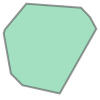

In [7]:
def random_polygon(
    radius_mean: float = 2,
    radius_sigma: float = 1.5,
):
    """Generates the simplest of polygons, a triangle with a size described by a random polygon.

    Args:
        radius_mean: The average radius defining a circumcircle of a triangle.
        radius_sigma: The variance of a radius defining a circumcircle of a triangle.

    Returns:
        A single polygon.
    """
    # define the number of corners
    number_of_corners = np.random.randint(3, 10)

    # generate cartesian coordinates from a radius and a sorted list of perigons.
    array = polar_to_cartesian(
        np.random.lognormal(radius_mean, radius_sigma),
        np.sort(np.random.rand(number_of_corners)),
    )

    # add an offset
    offset = np.random.randint(low=-SIZE_ROUTE, high=SIZE_ROUTE, size=(2,))
    return_values = np.zeros((number_of_corners, 2), dtype=float)

    return_values[:] = offset
    return_values[:, :] += np.array((np.real(array), np.imag(array))).T
    return Polygon(return_values)


np.random.seed(42)
random_polygon()

### Parameter zum Generieren der Karte

Die folgenden Parameter wurden für das Generieren von Karten genutzt:
* `radius_mean = 2` 
* `radius_sigma = 1`
* `number_of_polygons = 40`

In [8]:
def generate_obstacles(
    seed: Optional[int] = None,
    number_of_polygons: int = 40,
    radius_mean: float = 2,
    radius_sigma: float = 1,
) -> dict[str, Polygon]:
    """Generates a set of obstacles from a union of triangles.

    The union of triangles meas that if polygons overlap o polygon containing the union of those polygons is returned.
    Args:
        seed: A seed to generate a set of obstacles from.
        number_of_polygons: The number of polygons that should be drawn.
        radius_mean: The average radius defining a circumcircle of an obstacle triangle.
        radius_sigma: The variance of a radius defining a circumcircle of an obstacle triangle.

    Returns:
        A list of unified obstacles.
    """
    # sets a seed
    if seed is not None:
        np.random.seed(seed)

    # generate a list of polygons
    polygons = []
    for _ in range(number_of_polygons):
        poly = random_polygon(radius_mean, radius_sigma)
        # skip polygons that are to close to the start int point P(0, 0)
        if poly.contains(Point(0, 0)):
            continue
        if poly.exterior.distance(Point(0, 0)) < 1:
            continue
        # append to polygon list
        polygons.append(poly)

    # build unions of all polygons
    polygon_list = list(unary_union(polygons).geoms)
    return {str(i): p for i, p in enumerate(polygon_list)}

### Generieren des Zieles

Zu jedem Scenario gehört neben einer Situation auch ein Ziel. Auch zum Generieren eines Ziels wurde zuerst der gleiche Seed gesetzt wie für den Kartengenerator. Danach wird eine zufällige Position mit Abstand zum Kartenrand ausgewählt.
Die so generierte Zielposition wird danach auf Plausibilität überprüft. Folgende Prüfungen finden statt:
1. Es wird sichergestellt dass, das Ziel nicht in oder an einem Hindernis liegt.
2. Eine Minimaldistanz in x und y wird sichergestellt. Leider ist hier ein Fehler passiert. Anstelle die Summe der absoluten Distanz zu prüfen wurden die Distanzen für X und Y separat geprüft was verhindert, dass Ziele über, unter und neben dem Startpunkt gefunden werden können. Zielpunkte werden nur in den äußeren vier Quadranten gefunden. Bedauerlicherweise ist dies erst aufgefallen als schon zu viel Zeit vergangen war und die Daten nicht neu generiert werden konnten. Dies sollte aber zumindest das Konzept dieser KI nicht beeinflussen. Wohl aber ihre direkte Anwendbarkeit.

In [9]:
def generate_destination(
    obstacles: dict[str, Polygon],
    seed: Optional[int] = None,
) -> Point:
    """Generates for a map.

    Can be used to generate a valid destination for list of obstacles.
    Args:
        obstacles: A list of obstacles.
        seed: The seed determining the point.

    Returns:
        A goal that should be reached by the ship.
    """
    # sets the seed
    if seed is not None:
        np.random.seed(seed)

    # generates the point
    point: Optional[Point] = None
    while (
        point is None
        or abs(point.x) < MIN_DESTINATION_DISTANCE
        or abs(point.y) < MIN_DESTINATION_DISTANCE
        or any(obstacle.contains(point) for obstacle in obstacles.values())
    ):
        point = Point(np.random.randint(-SIZE_INNER, SIZE_INNER, size=(2,), dtype=int))
    return point


print(generate_destination(generate_obstacles(42), 42))

POINT (-61 31)


In [10]:
def plot_situation(
    obstacles: dict[str, Polygon],
    destination: Point,
    obstacle_color: str | None = "RED",
    route=None,
    legend: bool = True,
    title: str | None = None,
) -> None:
    """PLots the obstacles into a matplotlib plot.

    Args:
        obstacles: A list of obstacles.
        destination: The destination that should be reached by the boat.
        obstacle_color: The color the obstacles should have. Can be None.
        If none all obstacles will have different colors.
        route: The route that should be plotted.
        legend: If true plots a legend.
        title: The title of the plot.
    Returns:
        None
    """
    # Create a plot in the defined size
    plt.axis([-SIZE_ROUTE, SIZE_ROUTE, -SIZE_ROUTE, SIZE_ROUTE])

    # Sets a title if one is demanded
    if title:
        plt.title(title)

    # Plots the obstacles.
    if obstacles:
        for polygon in obstacles.values():
            if obstacle_color is not None:
                plt.fill(*polygon.exterior.xy, color=obstacle_color, label="Obstacle")
            else:
                plt.fill(*polygon.exterior.xy)

    # Plots the wind direction
    # The following code for an arrow was taken modeled after:
    # https://www.geeksforgeeks.org/matplotlib-pyplot-arrow-in-python/
    plt.arrow(
        0,
        +int(SIZE_ROUTE * 0.9),
        0,
        -int(SIZE_ROUTE * 0.1),
        head_width=10,
        width=4,
        label="Wind (3Bft)",
    )

    if route is not None:
        if isinstance(route, np.ndarray):
            plt.plot(route[:, 0], route[:, 1], color="BLUE", marker=".")
        else:
            if isinstance(route, TimingFrame):
                plt.plot(
                    route.points[:, 0], route.points[:, 1], color="BLUE", marker="."
                )
            else:
                raise TypeError()

    # Plots the estimation
    if destination:
        plt.scatter(*destination.xy, marker="X", color="green", label="Destination")
    plt.scatter(0, 0, marker="o", color="green", label="Start")

    if legend:
        # https://stackoverflow.com/questions/13588920/stop-matplotlib-repeating-labels-in-legend
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())
    return None

Die aus den Seeds 0 - 11 generierten Karten werden unten angezeigt um Beispiele der von der KI zu lösenden Scenario zu zeigen.
Wird dieses Notebook im Pyrate Docker Container ausgeführt werden auch die Routen eingezeichnet.

  0%|          | 0/12 [00:00<?, ?it/s]

/pyrate/pyrate/plan/nearplanner/cost_functions.py:131: RuntimeWarning: overflow encountered in double_scalars
  grad = -cost * self.scale * self.safety_dist / dist**2 if dist > 0 else 0


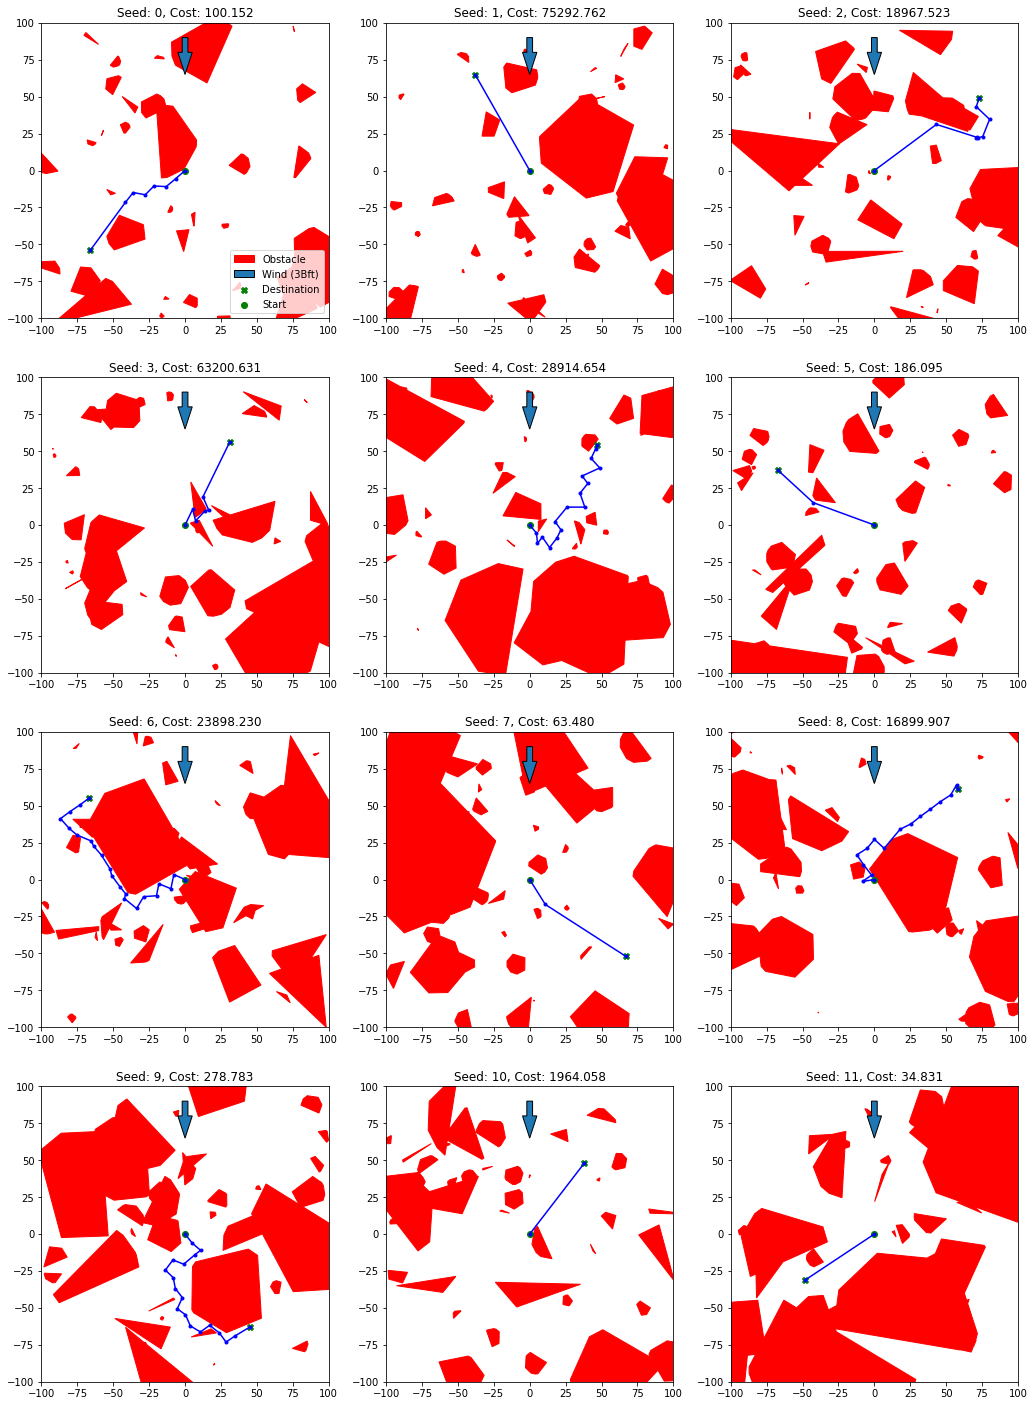

In [11]:
if not NO_SHOW:
    # create a subplot with 12 routes.
    plt.figure(figsize=(17.5, 25))
    for seed in tqdm(range(12)):
        plt.subplot(4, 3, seed + 1)
        generated_obstacles = generate_obstacles(seed)
        generated_destination = generate_destination(generated_obstacles, seed)
        route_generated = None

        # try to generate a route
        try:
            route_generated, _ = experiments.generate_route(
                position=Point(0, 0),
                goal=generated_destination,
                obstacles=generated_obstacles,
                wind=(18, 180),
            )
        except Exception:
            route_generated = None

        # plot the situation
        plot_situation(
            obstacles=generated_obstacles,
            destination=generated_destination,
            obstacle_color="RED",
            route=route_generated,
            title=f"Seed: {seed}, Cost: {route_generated.cost:.3f}"
            if route_generated
            else f"Seed: {seed}",
            legend=(seed == 0),
        )
    plt.show()

### Das Normieren der Scenarios

Um für ein neuronales Netz verständlich zu sein, ist es immer einfacher, wenn Eingaben normiert sind. Hier wurde entschieden die Szenarios, als Bilddaten zu normieren. 128 x 128 Pixel sind wesentlich gleichförmiger als eine Mange von maximal 40 Polygonen mit unterschiedlichen Formen. Daher verwandelt die folgende Funktion die mit den oben definierten Funktionen genierten Scenarios Datensätze in eine Bildform. Rot ist dabei das Hindernis. Grün das Ziel und Blau die Route. Entweder als Linie oder als Punkt, wenn die Route sich ändert.

In [12]:
# Inspiration:  https://programtalk.com/python-examples/PIL.ImageDraw.Draw.polygon/
def generate_image_from_map(
    obstacles: dict[str, Polygon],
    destination: Point,
    route=None,
    route_type: Literal["line", "dot"] = "dot",
) -> Image:
    """Generate an image from the map.

    Can be used to feed an ANN.
    - Obstacles are marked as reed.
    - The destination is marked as green.
    - The points where the route will likely change are blue.

    Args:
        obstacles: A dict of obstacles as shapely Polygons. Keyed as a string.
        destination: A destination that should be navigated to.
        route: The calculated route that should be followed.
        route_type: How the route is drawn. If 'line' is selected the complete route is selected.
            If 'dot' is selected the turning points a drawn in.
    """
    # generate an empty image (All black)
    img = Image.new(
        "RGB",
        (IMG_SIZE, IMG_SIZE),
        "#000000",
    )
    draw = ImageDraw.Draw(img)

    # draw in all obstacles in red
    for polygon in obstacles.values():
        draw.polygon(
            list(
                (np.dstack(polygon.exterior.xy).reshape((-1)) + SIZE_ROUTE)
                / (2 * SIZE_ROUTE)
                * IMG_SIZE
            ),
            fill="#FF0000",
            outline="#FF0000",
        )

    # draw in a route if possible. Does so in blue
    if os.getenv("PYRATE"):
        if isinstance(route, TimingFrame):
            route = route.points
    if route is not None:
        route = ((route + SIZE_ROUTE) / (2 * SIZE_ROUTE) * IMG_SIZE).astype(int)
        # draws the route as collection of lines
        if route_type == "line":
            draw.line([tuple(point) for point in route], fill=(0, 0, 0xFF))
        # draw the route as a collection of points. The starting point is seen as redundant and left out.
        elif route_type == "dot":
            for point in route[1:]:
                img.putpixel(point, (0, 0, 0xFF))
        else:
            raise ValueError("Route type unknown.")
    # draws in the destination in green
    img.putpixel(
        (
            int((destination.x + SIZE_ROUTE) / (2 * SIZE_ROUTE) * IMG_SIZE),
            int((destination.y + SIZE_ROUTE) / (2 * SIZE_ROUTE) * IMG_SIZE),
        ),
        (0, 0xFF, 0),
    )
    return img

In [13]:
def generate_example_image(route_type: Literal["line", "dot"]):
    """
    Generates an example image with the seed 42.

    Args:
        route_type: How the route is drawn. If 'line' is selected the complete route is selected.
            If 'dot' is selected the turning points a drawn in.

    Returns:
        The example image.
    """
    # generate obstacles and a destination
    obstacles = generate_obstacles(42)
    destination = generate_destination(obstacles, 42)
    # try to generate a route
    try:
        route, _ = experiments.generate_route(
            position=Point(0, 0),
            goal=destination,
            obstacles=obstacles,
            wind=(18, 180),
        )
    except Exception:
        route = None

    # draw the scenario
    return generate_image_from_map(
        obstacles=obstacles,
        destination=destination,
        route=route,
        route_type=route_type,
    )

Nachfolgend werden zwei solcher Scenarios Bilder gezeigt. Zuerst aber wird zum Vergleich das Scenario mit dem Seed 42 als Karte dargestellt, um den Unterschied zu zeigen.

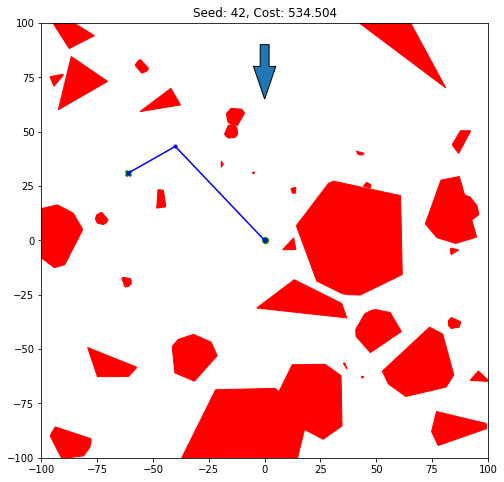

In [14]:
if not NO_SHOW:
    # set the default seed of 42
    seed: int = 42
    # create a figure
    plt.figure(figsize=(8, 8))
    wind_dir = 180
    # generate obstacles and a destination
    generated_obstacles = generate_obstacles(seed)
    generated_destination = generate_destination(generated_obstacles, seed)
    route_generated = None
    # try generating a route
    try:
        route_generated, _ = experiments.generate_route(
            position=Point(0, 0),
            goal=generated_destination,
            obstacles=generated_obstacles,
            wind=(18, wind_dir),
        )
    except Exception as e:
        route_generated = None
    # plotting the situation
    plot_situation(
        obstacles=generated_obstacles,
        destination=generated_destination,
        obstacle_color="RED",
        route=route_generated,
        title=f"Seed: {seed}, Cost: {route_generated.cost:.3f}"
        if route_generated
        else f"Seed: {seed}",
        legend=seed == 0,
    )
    plt.show()

Zeigt das Scenario mit dem Seed 42 mit eingezeichneten Wendepunkten, wenn dieses Notebook im Pyrate Docker Container ausgeführt wurde. Wichtig zu beachten ist in dieser Darstellung die Drehung des Vorzeichens der Y Achse was zu einer Horizontalen Spiegelung der Darstellung führt.

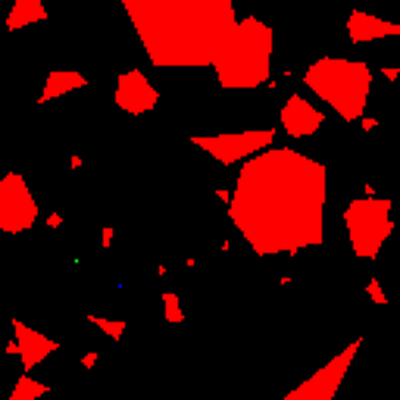

In [15]:
generate_example_image(route_type="dot").resize(
    (IMG_SHOW_SIZE, IMG_SHOW_SIZE), Image.Resampling.BICUBIC
)

Zeigt das Scenario mit dem Seed 42 mit einer, durch Linien eingezeichneten Route, wenn dieses Notebook im Pyrate Docker Container ausgeführt wurde.

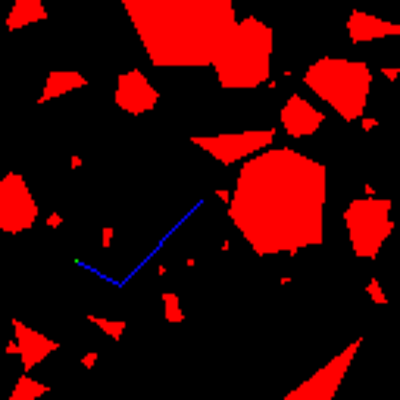

In [16]:
generate_example_image(route_type="line").resize(
    (IMG_SHOW_SIZE, IMG_SHOW_SIZE), Image.Resampling.BICUBIC
)

### Massengenerierung von Szenarien

Die oben definierten Funktionen generieren immer einen Datensatz.
Die folgenden Funktionen definieren einen einzelnen Datensatz als `pd.Series` einer einzelnen Zeile in einem `pd.DataFrame`. Die so erzeugten Datensatze werden in `pd.DataFrames` zusammengefasst. Hier wurde eine Anzahl von 50 Datensätzen auf einmal gewählt. Diese werden dann gespeichert, um danach mehr Daten zu generieren. Da der Wegfindealgorithmus immer noch experimentell ist, werden für Routen, für die keine Lösung gefunden wurde oder bei deren finden ein Fehler auftritt wird dort `NaN` eingetragen.

In [17]:
def generate_all_to_series(
    seed: Optional[int] = None, image: bool = False
) -> pd.Series:
    """Generates everything and aggregates all data into a `pd:Series`.

    Args:
        seed:The seed that should be used to generate map and destination.
        image: If an image should be generated or if that should be postponed to save memory.
    Returns:
        Contains a `pd.Series`containing the following.
        - The seed tha generated the map.
        - The destination in x
        - The destination in y
        - A list of Obstacle polygons.
        - The route generated for this map by the roBOOTer navigation system.
        - Optionally the image containing all the information.
          Can be generated at a later date without the fear for a loss of accuracy.
    """
    # generate obstacles
    obstacles = generate_obstacles(seed)
    # find a destination
    destination = generate_destination(obstacles, seed)

    # find a possible route
    try:
        route, _ = experiments.generate_route(
            position=Point(0, 0),
            goal=destination,
            obstacles=obstacles,
            wind=(18, wind_dir),
        )
    except Exception:
        route = None

    # collect all generated data in a `pd.Series`
    return pd.Series(
        data={
            "seed": str(seed),
            "obstacles": obstacles,
            "destination_x": destination.x,
            "destination_y": destination.y,
            "image": generate_image_from_map(obstacles, destination, route)
            if image
            else pd.NA,
            "route": route.points if route else pd.NA,
            "cost": route.cost if route else pd.NA,
        },
        name=str(seed),
    )

Nachfolgend wird ein kurzes Beispiel eines solchen `pd.DataFrame` angezeigt.

In [18]:
if os.path.exists("test.pickle"):
    df = pd.read_pickle("test.pickle")
else:
    df = pd.DataFrame(
        [generate_all_to_series(i, image=False) for i in tqdm(range(12))]
    ).set_index("seed")
    df.to_pickle("test.pickle")
df

  0%|          | 0/12 [00:00<?, ?it/s]

/pyrate/pyrate/plan/nearplanner/cost_functions.py:131: RuntimeWarning: overflow encountered in double_scalars
  grad = -cost * self.scale * self.safety_dist / dist**2 if dist > 0 else 0


obstacles  destination_x  \
seed                                                                     
0     {'0': POLYGON ((-17.62168766659423 -98.3692662...          -66.0   
1     {'0': POLYGON ((-97.82715137072381 -82.2211677...          -38.0   
2     {'0': POLYGON ((-46.23706006792075 -76.7569948...           73.0   
3     {'0': POLYGON ((-7.4210414351932155 -83.111096...           31.0   
4     {'0': POLYGON ((-77.97638439917915 -70.2390972...           47.0   
5     {'0': POLYGON ((-71.45682729091783 -138.627922...          -67.0   
6     {'0': POLYGON ((-76.20025009472265 -92.9434076...          -67.0   
7     {'0': POLYGON ((10.806865516434499 -102.670968...           67.0   
8     {'0': POLYGON ((-38.740101054728726 -89.986420...           58.0   
9     {'0': POLYGON ((-28.332925461055822 -73.516031...           45.0   
10    {'0': POLYGON ((-42.90670292182745 -82.5864109...           38.0   
11    {'0': POLYGON ((-124.01583316741481 -73.449792...          -48.0   

      destination_y image                                              route  \
seed                                                                           
0             -54.0  <NA>  [[0.0, 0.0], [-6.514627334268863, -5.502693040...   
1              65.0  <NA>                        [[0.0, 0.0], [-38.0, 65.0]]   
2              49.0  <NA>  [[0.0, 0.0], [43.20648551245758, 31.2114102262...   
3              56.0  <NA>  [[0.0, 0.0], [5.303962239032221, 10.6856391688...   
4              54.0  <NA>  [[0.0, 0.0], [4.691900284503645, -5.4114328014...   
5              37.0  <NA>  [[0.0, 0.0], [-42.539218405821984, 15.14880405...   
6              55.0  <NA>  [[0.0, 0.0], [-7.80975254664349, 3.41866699781...   
7             -52.0  <NA>  [[0.0, 0.0], [10.886352485821806, -16.87002927...   
8              61.0  <NA>  [[0.0, 0.0], [-8.211437427025228, -1.293253961...   
9             -63.0  <NA>  [[0.0, 0.0], [4.916904836271752, -6.0148314241...   
10             48.0  <NA>                         [[0.0, 0.0], [38.0, 48.0]]   
11            -31.0  <NA>                       [[0.0, 0.0], [-48.0, -31.0]]   

              cost  
seed                
0       100.151629  
1     75292.761936  
2     18967.522925  
3     63200.630758  
4     28914.654143  
5       186.095369  
6     23898.229531  
7        63.479684  
8     16899.906926  
9       278.782639  
10     1964.057914  
11       34.830618

Die folgende Zelle ist Verantwortlich für das massenweise Generieren von Trainingsdaten. Sie kann entweder so eingestellt werden, dass nur eine einzige Batch aus 50 neuen Datensätzen generiert werden soll oder eine ganze Reihe von Batches. Sind nicht alle Anforderungen zum Ausführen der Zelle erfüllt, wird sie automatisch übersprungen.

```pyrate
# Skips the following cell if the code can't be executed.
if os.getenv("PYRATE"):
    save_frequency = int(os.getenv("save_frequency", "50"))
    start_seed = int(os.getenv("seed_start", "0"))
    continues = bool(os.getenv("continues", "false"))

    # try finding a block of seeds that is not used
    files = glob.glob("data/raw*.pickle") + glob.glob("data/tmp*.pickle")
    seed_groups = {int(file[9:-7]) for file in files}
    for next_seeds in range(start_seed, 1_000_000, save_frequency):
        # skip if the seed block already exists or is generated by another instance if this notebook
        if next_seeds in seed_groups:
            continue

        # start generating routes for the seed block
        print(f"Start generating routes for seed: {next_seeds}")

        # reserving the seed block by looking down the seed block with an empty file
        tmp_pickle_str: str = f"data/tmp_{next_seeds:010}.pickle"
        pd.DataFrame().to_pickle(tmp_pickle_str)

        # generate the data
        df = pd.DataFrame(
            [
                generate_all_to_series(i, image=False)
                for i in tqdm(range(next_seeds, next_seeds + save_frequency, 1))
            ]
        ).set_index("seed")

        # saves the data and delete the temporary file
        pickle_to_file = f"data/raw_{next_seeds:010}.pickle"
        df.to_pickle(pickle_to_file)
        os.remove(tmp_pickle_str)

        # break the loop if only a single block of data should be generated.
        if not continues:
            break
```

### Daten zusammenfassen

Nachdem man den generierenden Teil des Codes für eine Weile hat laufen lassen, erhält man eine Vielzahl einzelner Dateien. Diese werden nachfolgend zusammengefasst. Diese so zusammengefasste Tabelle wird nachfolgend von Ausreißern und Fehlern bereinigt.
Direkt nach dem Zusammenfassen der Daten werden alle Einträge, für die keine Routen gefunden wurde, weggelassen.

Dies kann folgende Gründe haben:
* Startpunkt $P(0, 0)$ ist von Hindernissen eingeschlossen
* Der Zielpunkt ist von Hindernissen eingeschlossen
* Fehler im Algorithmus der die Routen generiert

In [19]:
DATA_COLLECTION_PATH: Final[str] = "data/collected.pickle"

# Load a cached result should it not be demanded to generate all data new.
if os.path.exists(DATA_COLLECTION_PATH) and not GENERATE_NEW:
    collected_data = pd.read_pickle(DATA_COLLECTION_PATH)
else:
    # Read the first n files
    # The number of files read can be defined with the constant: NUMBER_OF_FILES_LIMIT
    # The dataframes read are concatenate directly after
    collected_data = pd.concat(
        [
            pd.read_pickle(filename)
            for filename in tqdm(glob.glob("data/raw_*.pickle")[:NUMBER_OF_FILES_LIMIT])
        ]
    )
# Prints a short summary of the data.
number_of_maps = len(collected_data.index)
print(f"{number_of_maps: 8} maps collected")
collected_data.dropna(subset=["route"], inplace=True)
number_of_routes = len(collected_data.index)
print(f"{number_of_routes: 8} routes collected")
collected_data.to_pickle(DATA_COLLECTION_PATH)
collected_data

  0%|          | 0/500 [00:00<?, ?it/s]

   25000 maps collected
   23280 routes collected


obstacles  destination_x  \
seed                                                                      
0      {'0': POLYGON ((-17.62168766659423 -98.3692662...          -66.0   
1      {'0': POLYGON ((-97.82715137072381 -82.2211677...          -38.0   
2      {'0': POLYGON ((-46.23706006792075 -76.7569948...           73.0   
3      {'0': POLYGON ((-7.4210414351932155 -83.111096...           31.0   
4      {'0': POLYGON ((-77.97638439917915 -70.2390972...           47.0   
...                                                  ...            ...   
25045  {'0': POLYGON ((-80.44890007800937 -70.4569634...          -67.0   
25046  {'0': POLYGON ((-63.55966988255701 -93.6258511...          -44.0   
25047  {'0': POLYGON ((-63.7334990739641 -93.02063274...          -34.0   
25048  {'0': POLYGON ((-66.53560391342282 -88.9214851...          -34.0   
25049  {'0': POLYGON ((-31.03667561920566 -52.0295076...           49.0   

       destination_y image                                              route  \
seed                                                                            
0              -54.0  <NA>  [[0.0, 0.0], [-6.514627334268863, -5.502693040...   
1               65.0  <NA>                        [[0.0, 0.0], [-38.0, 65.0]]   
2               49.0  <NA>  [[0.0, 0.0], [43.20648551245758, 31.2114102262...   
3               56.0  <NA>  [[0.0, 0.0], [5.303962239032221, 10.6856391688...   
4               54.0  <NA>  [[0.0, 0.0], [4.691900284503645, -5.4114328014...   
...              ...   ...                                                ...   
25045          -27.0  <NA>  [[0.0, 0.0], [-4.984525555905634, 5.2282410983...   
25046          -65.0  <NA>  [[0.0, 0.0], [-4.3999999999999995, -6.50000000...   
25047           47.0  <NA>  [[0.0, 0.0], [-14.236853557702911, 5.258136784...   
25048           29.0  <NA>                        [[0.0, 0.0], [-34.0, 29.0]]   
25049           59.0  <NA>                         [[0.0, 0.0], [49.0, 59.0]]   

               cost  
seed                 
0        100.151629  
1      75292.761936  
2      18967.522925  
3      63200.630758  
4      28914.654143  
...             ...  
25045    309.600598  
25046    191.114502  
25047   38963.48483  
25048    152.757587  
25049   1438.645384  

[23280 rows x 6 columns]

### Szenarios Filtern

Die so erzeugten Daten sind ungefiltert. Sie müssen nun überprüft werden. Dazu wurden einige hundert Datensätze geplottet. Einige Muster sind dabei aufgefallen. Die nachfolgenden Filter resultieren aus diesen Mustern.

#### Die Route verlässt die Karte

Das Generieren von Heatmaps von Segelrouten erfordert, dass sich das mögliche Ergebnis sinnvoll darstellen lässt. Dazu muss die Route vollständig im definierten Bereich liegen. Alle Routen, die die Karte verlassen, werden weggelassen.

In [20]:
def check_route_in_bounds(route):
    """
    Check if a route exists and is in bounds.

    Args:
        route: An `np.ndarray` of points the builds the route.

    Returns:
        A non-existing route or a route that leaves the area routes should stick to return `False` otherwise, `True` is returned.
    """

    # CHecks if the route exists
    if route is None:
        return False
    if route is pd.NA:
        return False
    # Checks if the route is of the right data type.
    if not isinstance(route, np.ndarray):
        return False
    # Checks if a position is out of bounds.
    if np.array(
        abs(route) > SIZE_ROUTE,
    ).any():
        return False
    return True


# Count the number of data points there are before this filter is used.
data_before = len(collected_data.index)

# Filtering
df_filter = collected_data["route"].apply(check_route_in_bounds)
filtered = collected_data[~df_filter]
collected_data = collected_data[df_filter]

# Count the number of data points there are after this filter is used.
data_after = len(collected_data.index)

# Print a short report over the changes to the dataset.
print(
    f"{data_before} - {data_before-data_after} = {data_after} sets of data remaining."
)

# delete variables that where only used inside this cell
del data_before, data_after, filtered, df_filter

23280 - 102 = 23178 sets of data remaining.


#### Routen auf Fehler überprüfen

Ein Bug in der Routenfindung hat zu Selbstschneidung der Routen geführt dieser wurde beim Sailing Team Darmstadt e.V. behoben. In den ersten ca. 27000 datensätzen gibt es dennoch Selbstschneidungen der Routen. Routen mit Selbstschneidung werden hier erkannt und da weder representativ noch richtig aus diesem Datensatz herausgenommen.

In [21]:
def check_route_self_crossing(route):
    """
    Check if a route has self intersections.

    Args:
        route: An `np.ndarray` of points the builds the route.

    Returns:
        `True` if the route is self intersecting.
    """
    if isinstance(route, float):
        print(float)
    return not LineString(route).is_simple


# count the number of data points before this filter was applied.
data_before = len(collected_data.index)

# filter the data
collected_data = collected_data[
    ~collected_data["route"].apply(check_route_self_crossing)
]

# count the number of data points after this filter was applied.
data_after = len(collected_data.index)

# print a short report over the changes to the dataset.
print(
    f"{data_before} - {data_before-data_after} = {data_after} sets of data remaining."
)

# delete variables that where only used inside this cell
del data_before, data_after

23178 - 2080 = 21098 sets of data remaining.


#### Filtern der Routen nach Kosten

Einige der Routen haben trotz einer erfolgreichen Routenfindung enorm hohe Kosten. Kosten werden beim Generieren der Route mitberechnet und sind das, was bei dem Routen generierenden Gradientenabstiegsverfahren optimiert wird. Sie setzen sich zusammen aus Segelzeit und Risiken. Außerordentlich hohe Kosten legen daher entwendet nahe, dass keine gute Route gefunden werden konnte oder dass die gefundene Route zu einem schlechten lokalen Minimum konvergiert hat. Daher werden die teuersten $5\%$ der Routen weggelassen.

Die folgende Route berechnet das $95\%$ Quantil und errechnet wie viele Einträge über $95\%$ liegen.

In [22]:
QUANTILE_LIMIT: Final[float] = 0.95
if "DATA_UPPER_LIMIT_QUANTIL" not in locals():
    DATA_UPPER_LIMIT_QUANTIL: Final[float] = collected_data["cost"].quantile(
        QUANTILE_LIMIT
    )
    OVER_QUANTILE: Final[int] = int(len(collected_data.index) * (1 - QUANTILE_LIMIT))
# noinspection PyUnboundLocalVariable
print(
    f"{OVER_QUANTILE} entries over the {QUANTILE_LIMIT} quantile at {DATA_UPPER_LIMIT_QUANTIL:.3f}"
)

1054 entries over the 0.95 quantile at 39452.885


Der folgende Codeschnipsel berechnet das Histogramm der Kosten. Wie wenig repräsentativ die höchsten $5\%$ der Kosten sind, ist direkt ersichtlich.

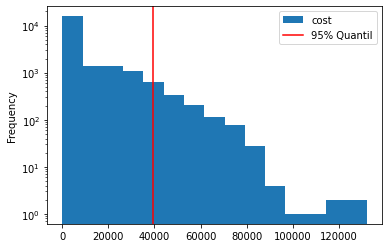

In [23]:
collected_data["cost"].plot.hist(bins=15, log=True)
plt.axvline(x=DATA_UPPER_LIMIT_QUANTIL, color="RED", label="95% Quantil")
plt.legend()
plt.show()

Nachfolgend werden einige der Routen mit sehr hohen Kosten gezeigt. Die meisten kommen dem Land sehr nahe oder segeln sehr stark gegen den Wind.

  0%|          | 0/12 [00:00<?, ?it/s]

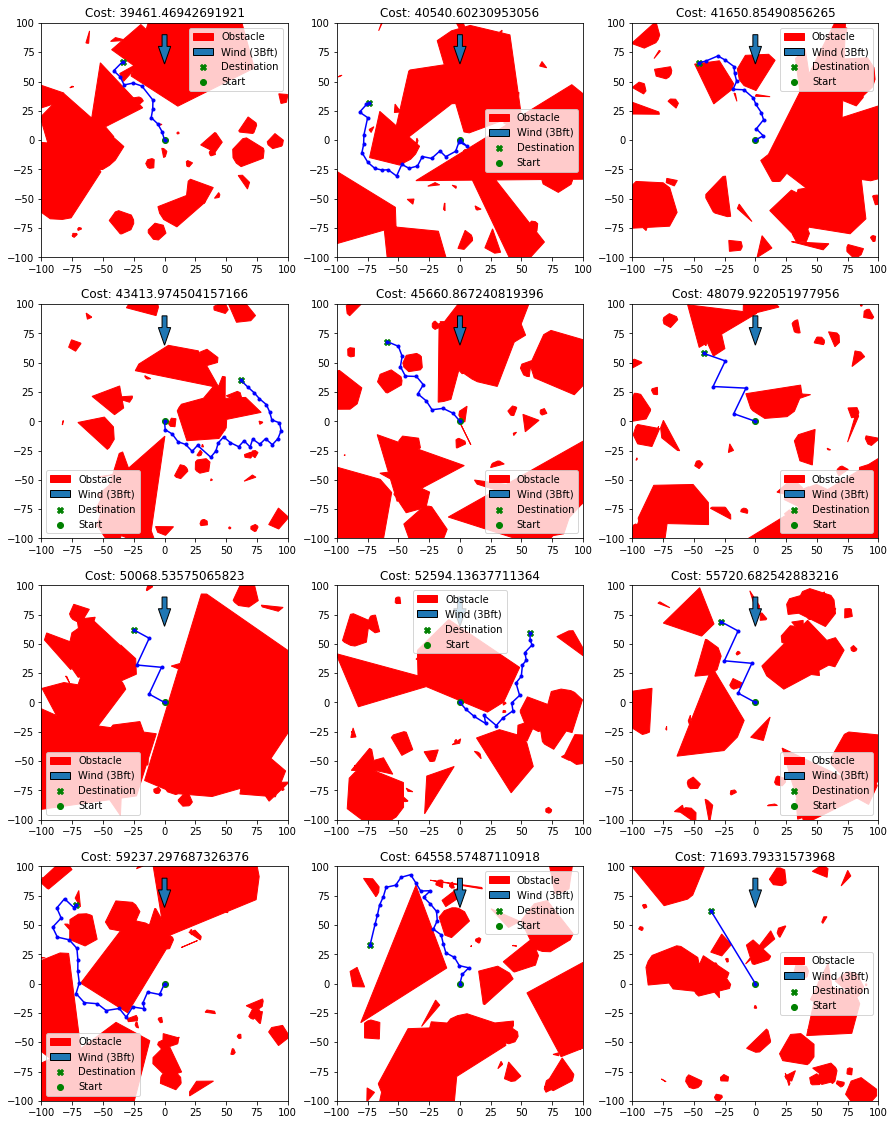

In [24]:
plt.figure(figsize=(15, 25))
for count, (seed, row) in tqdm(
    enumerate(
        collected_data[collected_data["cost"] > DATA_UPPER_LIMIT_QUANTIL]
        .sort_values("cost")
        .iloc[0 :: int(OVER_QUANTILE / 12)]
        .iloc[:12]
        .iterrows()
    ),
    total=12,
):
    plt.subplot(5, 3, count + 1)
    plot_situation(
        destination=Point(row.destination_x, row.destination_y),
        obstacles=row.obstacles,
        obstacle_color="RED",
        route=row.route,
        title=f"Cost: {row.cost}",
    )
plt.show()

Die Daten werden nun beim $95\%$ Quantil der Kosten gefiltert.

In [25]:
collected_data = collected_data.loc[collected_data["cost"] < DATA_UPPER_LIMIT_QUANTIL]
collected_data

obstacles  destination_x  \
seed                                                                      
0      {'0': POLYGON ((-17.62168766659423 -98.3692662...          -66.0   
2      {'0': POLYGON ((-46.23706006792075 -76.7569948...           73.0   
4      {'0': POLYGON ((-77.97638439917915 -70.2390972...           47.0   
5      {'0': POLYGON ((-71.45682729091783 -138.627922...          -67.0   
6      {'0': POLYGON ((-76.20025009472265 -92.9434076...          -67.0   
...                                                  ...            ...   
25045  {'0': POLYGON ((-80.44890007800937 -70.4569634...          -67.0   
25046  {'0': POLYGON ((-63.55966988255701 -93.6258511...          -44.0   
25047  {'0': POLYGON ((-63.7334990739641 -93.02063274...          -34.0   
25048  {'0': POLYGON ((-66.53560391342282 -88.9214851...          -34.0   
25049  {'0': POLYGON ((-31.03667561920566 -52.0295076...           49.0   

       destination_y image                                              route  \
seed                                                                            
0              -54.0  <NA>  [[0.0, 0.0], [-6.514627334268863, -5.502693040...   
2               49.0  <NA>  [[0.0, 0.0], [43.20648551245758, 31.2114102262...   
4               54.0  <NA>  [[0.0, 0.0], [4.691900284503645, -5.4114328014...   
5               37.0  <NA>  [[0.0, 0.0], [-42.539218405821984, 15.14880405...   
6               55.0  <NA>  [[0.0, 0.0], [-7.80975254664349, 3.41866699781...   
...              ...   ...                                                ...   
25045          -27.0  <NA>  [[0.0, 0.0], [-4.984525555905634, 5.2282410983...   
25046          -65.0  <NA>  [[0.0, 0.0], [-4.3999999999999995, -6.50000000...   
25047           47.0  <NA>  [[0.0, 0.0], [-14.236853557702911, 5.258136784...   
25048           29.0  <NA>                        [[0.0, 0.0], [-34.0, 29.0]]   
25049           59.0  <NA>                         [[0.0, 0.0], [49.0, 59.0]]   

               cost  
seed                 
0        100.151629  
2      18967.522925  
4      28914.654143  
5        186.095369  
6      23898.229531  
...             ...  
25045    309.600598  
25046    191.114502  
25047   38963.48483  
25048    152.757587  
25049   1438.645384  

[20043 rows x 6 columns]

Ein neues Histogramm der Kostenfunktion wird geplottet.

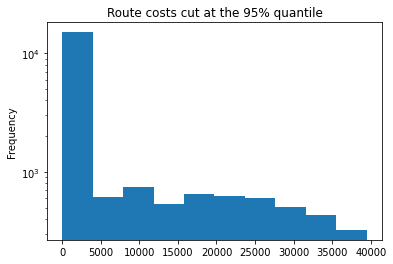

In [26]:
collected_data["cost"].plot.hist(log=True)
plt.title("Route costs cut at the 95% quantile")
plt.show()

#### Filtern der Routen nach Komplexität

Gegenüber den Routen mit zu hohen Kosten stehen die Routen mit zu geringen Kosten. Daher werden als nächstes Routen mit zu niedrigen Kosten betrachtet.
Nachfolgend ist eine Auswahl solcher günstiger Routen angezeigt. Es fällt auf das, all diese Routen direkt sind.
Eine Betrachtung der Verteilung der Routenpunkte ist daher notwendig.

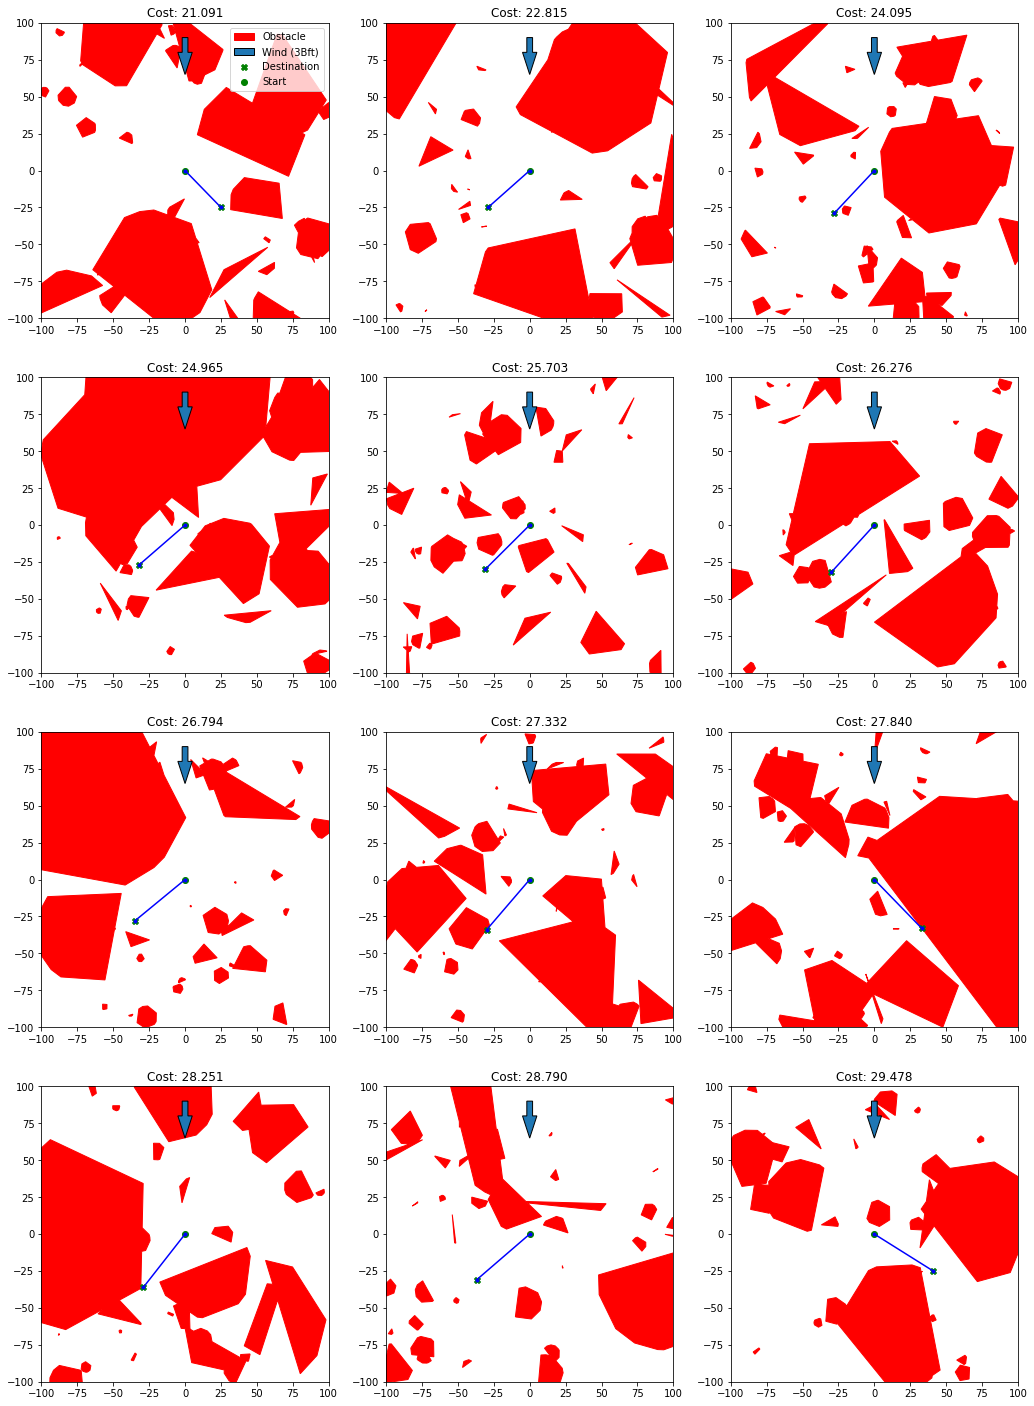

In [27]:
plt.figure(figsize=(17.5, 25))
for count, (seed, row) in enumerate(
    collected_data[collected_data["cost"] < DATA_UPPER_LIMIT_QUANTIL]
    .sort_values("cost")
    .iloc[1:600:51]
    .iterrows()
):
    plt.subplot(4, 3, count + 1)
    plot_situation(
        destination=Point(row.destination_x, row.destination_y),
        obstacles=row.obstacles,
        obstacle_color="RED",
        route=row.route,
        title=f"Cost: {row.cost:.3f}",
        legend=count == 0,
    )
plt.show()
del seed

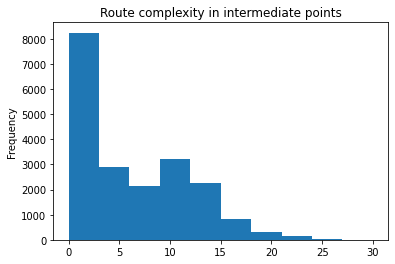

In [28]:
def get_route_points(data):
    """
    Counts how many stops are made inbetween.

    Args:
        data: a `pd.DataFrame` collecting all the data.
    Returns:

    """
    complexity = data["route"].apply(lambda r: r.shape[0] - 2)
    complexity.name = "route complexity"
    return complexity


route_points = get_route_points(collected_data)
route_points.plot.hist()
plt.title("Route complexity in intermediate points")
plt.show()

Bei der oben angezeigten Komplexität wird deutlich, das diese teilweise etwas hoch ist. Hier wird ein Limit von 15 Kursänderungen eingeführt.

In [29]:
routes_before = len(collected_data.index)
collected_data = collected_data[route_points <= 15]
routes_after = len(collected_data.index)
print(
    f"{routes_before} - {routes_before - routes_after} = {routes_after} "
    f"if only routes with less then 15 course changes remain."
)

20043 - 979 = 19064 if only routes with less then 15 course changes remain.


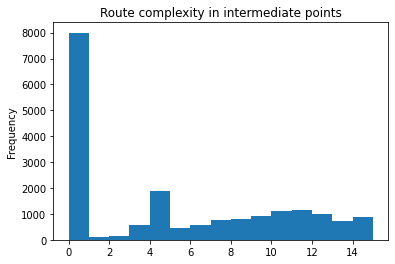

In [30]:
get_route_points(collected_data).plot.hist(bins=15)
plt.title("Route complexity in intermediate points")
plt.show()

Die nun reduzierte Anzahl der Routen enthält eine zwar representative Menge an sehr einfachen Routen. Da das Ergebnis dieser Routen aber eine leere Heat Map für Kursänderungen ist, muss hier deutlich reduziert werden sodas sie nur einen angegebenen Anteil am Gesamtvolumen ausmachen. Dieser Anteil wurde hier auf $5\%$ gesetzt.

In [31]:
# Define the upper limit of the percentage easy routes should reach
LIMIT_SIMPLE_CASES = 0.05
values = get_route_points(collected_data).value_counts().sort_index()
chance_limit = (
    (len(collected_data.index) * LIMIT_SIMPLE_CASES * (1 - LIMIT_SIMPLE_CASES))
    / values.get(0, 1)
    if 0 in values.index
    else 0
)
print(
    f"Limiting simple cases to {LIMIT_SIMPLE_CASES * 100:.1f}% of the total routes. Reducing simple routes to {(chance_limit * 100):.1f}% of their volume."
)

Limiting simple cases to 5.0% of the total routes. Reducing simple routes to 11.3% of their volume.


Der folgende Abschnitt setzt das oben aufgestellte Limit um.

In [32]:
np.random.seed = 0
collected_data = collected_data[
    (
        (get_route_points(collected_data) > 1)
        | (np.random.random(len(collected_data.index)) < chance_limit)
    )
]
del chance_limit

Die so veränderte Distribution der Routenkomplexität sieht dann so aus.

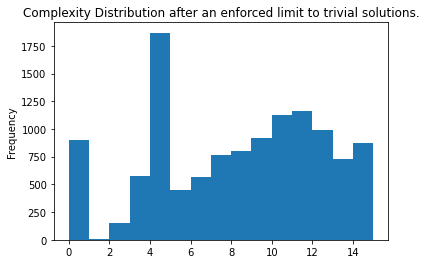

In [33]:
get_route_points(collected_data).plot.hist(bins=15)
plt.title("Complexity Distribution after an enforced limit to trivial solutions.")
plt.show()

Das `pd.DataFrame` welches die gefilterten Daten sammelt, sieht dann wie folgt aus:

In [34]:
collected_data

obstacles  destination_x  \
seed                                                                      
0      {'0': POLYGON ((-17.62168766659423 -98.3692662...          -66.0   
2      {'0': POLYGON ((-46.23706006792075 -76.7569948...           73.0   
4      {'0': POLYGON ((-77.97638439917915 -70.2390972...           47.0   
8      {'0': POLYGON ((-38.740101054728726 -89.986420...           58.0   
12     {'0': POLYGON ((-78.64598261951151 -82.5905995...           55.0   
...                                                  ...            ...   
25037  {'0': POLYGON ((-70.1543216286469 -126.2833218...          -62.0   
25044  {'0': POLYGON ((-94.3612368741144 -96.08652939...           70.0   
25045  {'0': POLYGON ((-80.44890007800937 -70.4569634...          -67.0   
25046  {'0': POLYGON ((-63.55966988255701 -93.6258511...          -44.0   
25047  {'0': POLYGON ((-63.7334990739641 -93.02063274...          -34.0   

       destination_y image                                              route  \
seed                                                                            
0              -54.0  <NA>  [[0.0, 0.0], [-6.514627334268863, -5.502693040...   
2               49.0  <NA>  [[0.0, 0.0], [43.20648551245758, 31.2114102262...   
4               54.0  <NA>  [[0.0, 0.0], [4.691900284503645, -5.4114328014...   
8               61.0  <NA>  [[0.0, 0.0], [-8.211437427025228, -1.293253961...   
12             -72.0  <NA>  [[0.0, 0.0], [7.15433954975134, 5.559264844101...   
...              ...   ...                                                ...   
25037           38.0  <NA>  [[0.0, 0.0], [-7.838432819436369, -0.057524750...   
25044           54.0  <NA>  [[0.0, 0.0], [-2.122974900266036, 8.5821312954...   
25045          -27.0  <NA>  [[0.0, 0.0], [-4.984525555905634, 5.2282410983...   
25046          -65.0  <NA>  [[0.0, 0.0], [-4.3999999999999995, -6.50000000...   
25047           47.0  <NA>  [[0.0, 0.0], [-14.236853557702911, 5.258136784...   

               cost  
seed                 
0        100.151629  
2      18967.522925  
4      28914.654143  
8      16899.906926  
12       177.415475  
...             ...  
25037    18101.3419  
25044  18061.452073  
25045    309.600598  
25046    191.114502  
25047   38963.48483  

[11883 rows x 6 columns]

### Das Konvertieren in trainierbare Daten

Die bisher erstellten und gefilterten Daten müssen nun mit der oben definierten Methode zum Generieren von Bildern `generate_image_from_map` transformiert werden. Die so transformierten Daten werden dann zusammengefasst und in ein `np.ndarray` konvertiert werden geeignet ist mehrdimensionale Arrays effizient zu speichern und zu bearbeiten. Durch das Speichern der Pixel als `uint8` war dies relative Speichereffizient.

In [35]:
def generate_image_maps(row, route_type: Literal["dot", "line"]):
    """Generates the image version of the route.

    Adds another dimension to prepare vor concatenation in a later step.
    Divides by 0xFF to contain only 0 and 1 and values.
    Color channel zero contains obstacles.
    Color channel one contains the destination.
    Color channel two contains the route either as course change points or as continues lines.

    Args:
        row: The row of the pd.DataFrame that should be used to generate an image.
        route_type: Defines if the route should be drawn as a collection of course change points or continues lines.
    Returns:
        The image modified for concatenation and scaled to be easily used for pandas.
        Cast as uint8 for a minimal memory consumption.
    """
    # expands the dimension by one
    img = np.expand_dims(
        # converts the image into a numpy array
        np.asarray(
            # generate the situation image form a map
            generate_image_from_map(
                obstacles=row.obstacles,
                destination=Point(row.destination_x, row.destination_y),
                route=row.route,
                route_type=route_type,
            )
        ),
        axis=0,
    )
    # integer divide to ensure all values are between 0 and 1
    img = img // 0xFF
    return img

In [36]:
# drop the image column to save some space in the dataset
if "image" in collected_data.columns:
    del collected_data["image"]

In [37]:
# save the collected and filtered data into a pickle file to load again later and flush the ram a bit.
DATA_WITH_IMG_PATH: Final[str] = "data/collected_and_filtered.pickle"
collected_data.to_pickle(DATA_WITH_IMG_PATH)

In [38]:
# collecting map images with routes as lines.
collected_routes = np.concatenate(
    collected_data.progress_apply(generate_image_maps, axis=1, args=("line",))
)

  0%|          | 0/11883 [00:00<?, ?it/s]

Die gesammelten Daten sind relativ groß die nachfolgende Operation zeigt an wie viel RAM dafür gerade belegt ist.

In [39]:
humanize.naturalsize(sys.getsizeof(collected_routes))

'584.1 MB'

Stellt sicher, dass `uint8` als Datentyp verwendet der ein minimum an Speicher verwendet.

In [40]:
assert (
    str(collected_routes.dtype) == "uint8"
), "Dtype needs to be unit8 to fit in the ram."

In [41]:
COLLECTED_ROUTES_LINE_DUMP = "data/collected_routes_np_line.pickle"
with open(COLLECTED_ROUTES_LINE_DUMP, "wb") as f:
    pickle.dump(collected_routes, f)

Generiert die Daten für das Line format.

In [42]:
# collecting map images with routes as dots.
collected_routes_dots = np.concatenate(
    collected_data.progress_apply(generate_image_maps, axis=1, args=("dot",))
)
assert (
    str(collected_routes_dots.dtype) == "uint8"
), "Dtype needs to be unit8 to fit in the ram."
COLLECTED_ROUTES_DOT_DUMP = "data/collected_routes_np_dot.pickle"
with open(COLLECTED_ROUTES_DOT_DUMP, "wb") as f:
    pickle.dump(collected_routes_dots, f)

# deletes the collection object
del collected_routes_dots

  0%|          | 0/11883 [00:00<?, ?it/s]

## Das Model


Jedes neuronale Netz, hat eine bestimmte *Form*, diese wird im Modell definiert. Die Form bestimmt die Anzahl der versteckten Schichten, ob beim Training spezielle Filter wie `Dropout` oder `BatchNormalization` verwendet werden sollen. Auch die Art der Aktivierungsfunktionen wird hier definiert.

Oft gibt es für bestimmte Probleme schon die eine oder andere Art von Netzwerkstruktur/Modellstruktur, die sich als geeignet erwiesen hat. Für diese Art von Problem, bei dem aus einem Bild eine anderes generiert werden soll, haben sich GAN Netzwerke als besonders Schlagfertig erwiesen [2], [3], [4].

GAN Netzwerke bestehen immer aus zwei Komponenten, einem `Generator` und einem `Discriminator`. Der `Generator` generiert ein Bild aus einem anderen Bild. Der `Discriminator` versucht die Bilder zu unterscheiden und weist so den `Gernerator` auf Fehler hin, die durch eine normale Lernfunktion mit einer $l_1$ oder $l_2$ Norm nicht hervorgehoben werden, weil es für diese oft reicht, wenn das Ziel ungefähr erreicht wird. Der `Discriminator` sorgt also für klare Kontraste und saubere Farbverläufe.

Das hier betrachtete Problem erwartet nun eine Heat Map. Da nicht davon auszugehen ist, dass die perfekte Route direkt gefunden wurde, ist ein etwas verwaschenes Ergebnis eine funktion nicht unbedingt ein Problem. Daher wird hier versucht den Routenschätzer ohne `Discriminator` aufzubauen.

### Der Generator

Der `Generator` ist eine Art von Autoencoder. Er nimmt das Bild, abstrahiert es in eine Sammlung von Features und generiert aus diesem Abstraction Format wieder ein Bild.
Der `Generator` besteht daher aus einer Reihe von *Downsamplern* gefolgt von ebenso vielen *Upsamplern*. Der Downsampler fasst alle zwei Pixel, 3 Pixel über ein `tf.keras.layers.Conv2D` Schicht zusammen. Symmetrisch dazu macht der Upsampler dies wieder rückgängig. So wird die Bildgröße mit jedem Downsampler Schicht halbiert und mit jedem Upsampler Schicht wieder verdoppelt. Dafür erhält jeder Downsampler mehr Features während der Upsampler Features reduziert. Up und Downsmapler sind meist Symmetrisch aufgebaut.
Wie in, sowohl dem TensorFlow Tutorial[4], als auch in dem Praxiseinstieg Maschine Learning in der Sektion über GANs[2] zu lesen ist benötigt der Downsampler eine `BatchNormaliszation` leaky Relu als Aktivierungsfunktion im Downsampler. Relu wird für den Upsampler verwendet.
* Relu `y = x if x >= 0 else 0`
* LeakyRelu `y = x if x >= 0 else b * x` wobei $x$ eine Zahl viel kleiner als 1 ist.

BatchNormalization normalisiert die Ausgabewerte einer Schicht über eine Training Batch, indem der Durchschnitt jeder Ausgangsschicht auf 0 geschoben wird und auf die Varianz 1 skaliert wird[5]. Beim Ausführen des Models wird die in der letzten Epoche festgelegte Gesamtbeschreibung und Skalierung genutzt. Dies sorgt zusammen mit dem DropOut Filter im Upsampler für ein konsistentes Lernen und verhindert das Overfitting.
Interessanterweise erhält jede Upsampling Schicht sowohl das Ergebnis, der vorherigen Schicht als auch das Ergebnis der symmetrischen Downsampling Schicht als Input.

In [43]:
# Source: https://www.tensorflow.org/tutorials/generative/pix2pix
def downsample(filters, size, apply_batchnorm=True):
    """Create a downsample layer.

    A downsample layer contains:
        * tf.keras.layers.Conv2D
        * An activation Function
        * Optional a batchnorm
        * A activation function (LeakyRelu)
    Args:
        filters: The number of features that should be gernated.
        size: The number of features / pixels should be reduced.
        apply_batchnorm: If True the Batchnorm is applied. Batch norms are used by default.
    Returns:
        A sequential model contain the keras generated layers.
    """

    initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(
            filters,
            size,
            strides=2,
            padding="same",
            kernel_initializer=initializer,
            use_bias=False,
        )
    )

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [44]:
# Source: https://www.tensorflow.org/tutorials/generative/pix2pix
def upsample(filters, size, apply_dropout=False):
    """Create a upsample layer.

    A downsample layer contains:
        * tf.keras.layers.Conv2D
        * An activation Function
        * Optional a batchnorm
        * A activation function (Relu)
    Args:
        filters: The number of features that should be used to upsample the layer.
        size: The number of
        apply_dropout: If True a dropout layer ist used.
    Returns:
        A sequential model contain the keras generated layers.
    """
    initializer = tf.random_normal_initializer(0.0, 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(
            filters,
            size,
            strides=2,
            padding="same",
            kernel_initializer=initializer,
            use_bias=False,
        )
    )

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

#### Model Erstellung
Erstellt ein erstes Model des Generators wie oben beschrieben. Ein schematisches Layout findet sich darunter.

2022-07-23 17:30:29.083718: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-23 17:30:29.083759: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-23 17:30:29.083784: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (f528564c4d5f): /proc/driver/nvidia/version does not exist
2022-07-23 17:30:29.084087: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


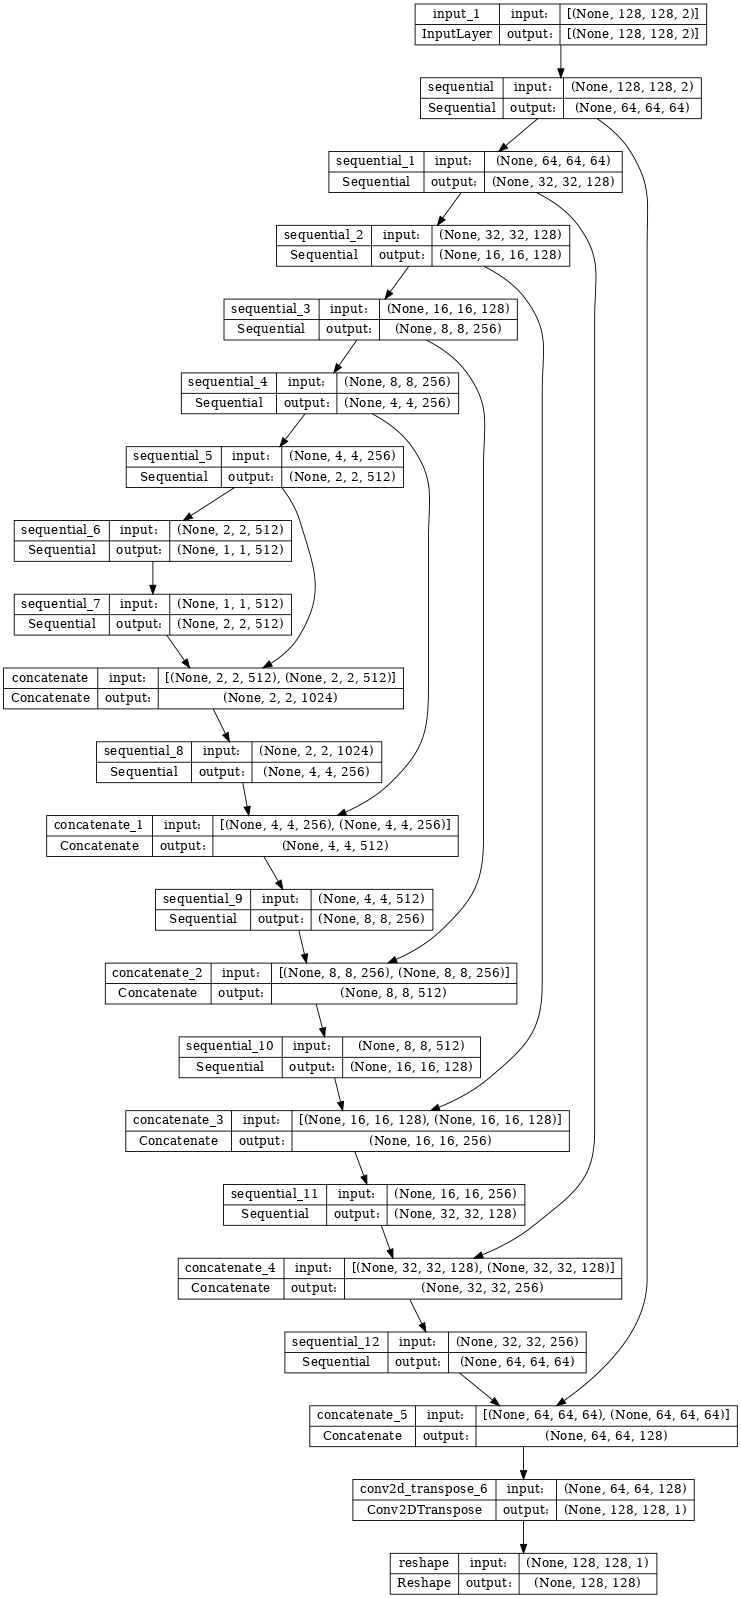

In [45]:
def model_generator() -> tf.keras.Model:
    """Creates an initial sequential model.

    Returns:
        A Sequential model.
    """

    inputs = tf.keras.layers.Input(shape=[IMG_SIZE, IMG_SIZE, 2])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 64, 64, 128)
        downsample(128, 4),  # (batch_size, 8, 8, 512)
        downsample(128, 4),  # (batch_size, 4, 4, 512)
        downsample(256, 4),  # (batch_size, 2, 2, 512)
        downsample(256, 4),  # (batch_size, 1, 1, 512)
        downsample(512, 4),  # (batch_size, 1, 1, 512)
        downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(256, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(256, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(128, 4),  # (batch_size, 16, 16, 1024)
        upsample(128, 4),  # (batch_size, 32, 32, 512)
        upsample(64, 4),  # (batch_size, 64, 64, 256)
    ]

    initializer = tf.random_normal_initializer(0.0, 0.02)
    last = tf.keras.layers.Conv2DTranspose(
        1,
        4,
        strides=2,
        padding="same",
        kernel_initializer=initializer,
        activation="sigmoid",  # was tanh
    )  # (batch_size, 256, 256, 3)

    x = inputs

    # Down sampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Up sampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    # drop the chanel dimension
    reshaped = tf.keras.layers.Reshape((128, 128))(x)

    return tf.keras.Model(inputs=inputs, outputs=reshaped)


tf.keras.utils.plot_model(model_generator(), show_shapes=True, dpi=64)

Um mehr Kontrolle über den Lernprozess zu haben werden Callbacks verwendet. Der EarlyStopping Callback verhindert vor allem das Verschwenden von Rechenzeit, indem er den Lernvorgang abbricht, wenn eine definierte Anzahl von Epochen, keine Verbesserung gefunden wurde. Verschlechtert sich die beobachtete Metric wird der Lernvorgang abgebrochen. Das beste Ergebnis wird wieder hergestellt was Overfitting verhindert. Der Callback betrachtet normalerweise den Validaion Loss Parameter.

In [50]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.00001,
    patience=10,
    verbose=0,
    mode="auto",
    restore_best_weights=True,
)

Nachfolgendes Diagramm zeigt die verschiedenen Farbkanäle der Eingabe und der Erwarteten ausgabe noch einmal separat und kombiniert.

  0%|          | 0/3 [00:00<?, ?it/s]

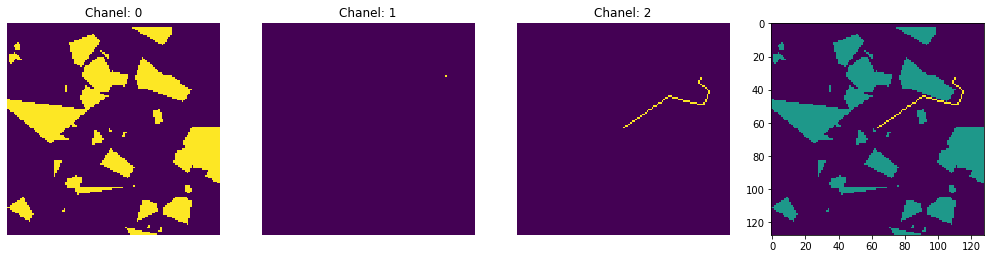

In [47]:
plt.figure(figsize=(17.5, 25))
np_array = np.flip(collected_routes[1, :, :, :], axis=0)

for chanel in tqdm(range(3)):
    plt.subplot(1, 4, chanel + 1)
    plt.title(f"Chanel: {chanel}")
    plt.imshow(np_array[:, :, chanel], interpolation="nearest")
    plt.axis("off")
plt.subplot(1, 4, 4)
plt.imshow(0x88 * np_array[:, :, 0] + 0xFF * np_array[:, :, 2], interpolation="nearest")
plt.show()

### Model Training

Das oben erstellte Model muss nun trainiert werden. Leider war es mir nicht möglich mehr als ein Model auf einmal im Speicher zu haben. Auch das Löschen von Modellen hat nicht erlaubt mehr als zwei Modelle in diesem Notebook zu trainieren.

Es wurde versucht, das Modell mit den Fehlerfunktionen `MSE`, `MAE`, `Binary Crossentropy` zu Trainieren. Die Ergebnisse waren sehr unterschiedlich.
* `MAE` Der *M*ean *A*verage *E*rror wird durch den Durchschnitt des absoluten Fehlers berechnet. Das Ergebnis war in diesem Fall ein annähernd blankes Ergebnis. Das Training schlug fehl. Durch die geringe Priorisierung von Ausreißern bei dieser Fehlerfunktion war dies zu erwarten.
* `MSE` Der *M*ean *S*quare *E*rror bildet den Durchschnitt über die Quadrate der Fehlerfunktion. Die dadurch verstärkt priorisierten Ausreißer erlaubten ein wesentlich besseres Lernverhalten.
* `Binary Crossentropy` Die Binary Crossentropy ist eine Fehlerfunktion für Wahrscheinlichkeitsfunktionen. Da wir hier eine Wahrscheinlichkeitsfunktion als Bild darstellen ist es die theoretisch am besten geeignete Funktion. Dies wurde experimentell bestätigt.

Das Training wurde mit $20\%$ der Daten als Validierungsdaten durchgeführt.
Experimentell hat sich gezeigt, dass die Ergebnisse schon mit der Standard Lernrate sehr gute Ergebnisse liefern. Diese werden mit einer geringeren Lernrate etwas besser auch, wenn der Lernaufwand so um ein Vielfaches größer ist.

Leider war es mir nicht möglich mehr als die Routen von 500 pickel Detain auf einmal mit meiner GPU zu trainieren. Es ist zu vermuten, dass ein besseres Ergebnis mit mehr Datensätzen erreicht werden kann. Ohne GPU war der Rechenaufwand dieses Trainings aber nicht praktikabel.

Als Optimierer wurde RMSprop verwendet.

#### Training des Modells mit Routen als Linien

Erstellt ein neues Model, Compiliert das Model und initialisiert die Schichten.
Danach wird das Model direkt trainiert.

In [51]:
# Delete the generator variable if already defined. Saves some gpu memory,
if "generator" in globals():
    print("Generator exists. Deleting for reset")
    del generator

# creates the model
generator = model_generator()

# compiles the model
generator.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),  #
    loss="binary_crossentropy",
    metrics=[
        "binary_crossentropy",
        "mean_squared_error",
        "mean_absolute_error",
    ],
)

# starts the training
history = generator.fit(
    collected_routes[:, :, :, :2],
    collected_routes[:, :, :, 2],
    validation_split=0.2,
    epochs=100,
    use_multiprocessing=False,
    workers=1,
    callbacks=[early_stop, tf.keras.callbacks.TerminateOnNaN()],
)

Generator exists. Deleting for reset
Epoch 1/100
298/298 [==============================] - 157s 524ms/step - loss: 0.1985 - binary_crossentropy: 0.1985 - mean_squared_error: 0.0474 - mean_absolute_error: 0.1644 - val_loss: 0.0344 - val_binary_crossentropy: 0.0344 - val_mean_squared_error: 0.0037 - val_mean_absolute_error: 0.0268
Epoch 2/100
298/298 [==============================] - 154s 517ms/step - loss: 0.0184 - binary_crossentropy: 0.0184 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0084 - val_loss: 0.0181 - val_binary_crossentropy: 0.0181 - val_mean_squared_error: 0.0031 - val_mean_absolute_error: 0.0045
Epoch 3/100
298/298 [==============================] - 155s 521ms/step - loss: 0.0163 - binary_crossentropy: 0.0163 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0061 - val_loss: 0.0168 - val_binary_crossentropy: 0.0168 - val_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0049
Epoch 4/100
298/298 [==============================] - 158s 530ms/step - loss:

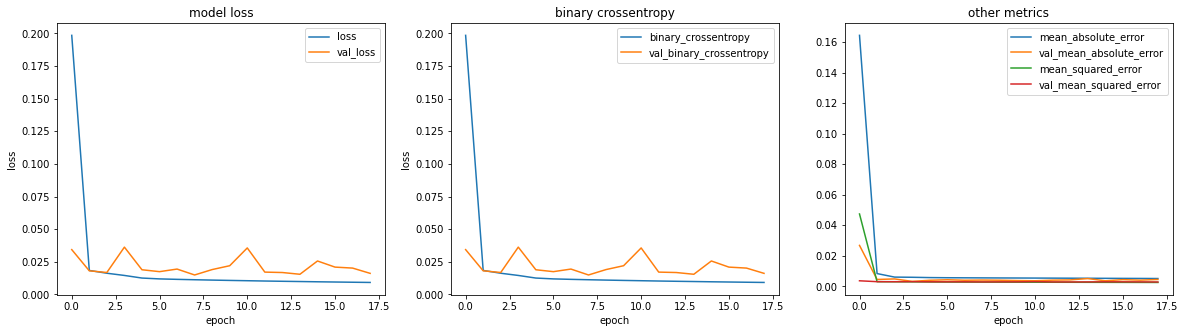

In [52]:
def plot_history(history_data, metrics: str | list) -> None:
    """Plot some metrics from a training history.

    Args:
        history_data: The history data to plot.
        metrics: The metrics that should be plotted.

    Returns:
        None
    """
    if isinstance(metrics, str):
        metrics = [metrics]
    for metric in metrics:
        plt.plot(history_data[metric], label=metric)
        plt.plot(history_data[f"val_{metric}"], label=f"val_{metric}")
    if len(metrics) == 1:
        plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(loc="best")


# Plots the training history in a single figure
plt.figure(figsize=(20, 5))

# plots the loss
plt.subplot(1, 3, 1)
plot_history(history.history, "loss")
plt.title("model loss")

# plots the binary cross entropy <-> equal to loss
plt.subplot(1, 3, 2)
plot_history(history.history, "binary_crossentropy")
plt.title("binary crossentropy")

# plots the other metrics
plt.subplot(1, 3, 3)
plot_history(history.history, ["mean_absolute_error", "mean_squared_error"])
plt.title("other metrics")

plt.show()

#### Betrachtung des trainierten Models mit Routen als Linien

Die besten Ergebnisse lagen bei einer `binary_crossentropy` von 0.0103 und einer `val_binary_crossentropy` von 0.0127 nach 51 Epochen bei einer Lernrate von 0.00001.
Bei dieser Art von Problem ist jedoch eine visuelle Überprüfung der Prediction notwendig.

In [53]:
def plot_predicted_data(model: tf.keras.Model, data: np.ndarray, pos=0) -> None:
    """Plots a single dataset in three versions.

    - The labeled situation.
    - The solution in context.
    - The prediction as a heat map.

    Flips everything for more consistency.

    Args:
        model: The trained model that should be visualised.
        data: The raw data that should be used as an example to visualise.
        pos: The position of the dataset that should be shown. If negativ test data is shown else training data is shown.

    Returns:
        None
    """
    plt.figure(figsize=(15, 5))
    tt = "test" if pos < 0 else "train"
    plt.title(f" for {tt} Nr: {abs(pos)}")
    data = data[pos, :, :, :]
    predicted = model.predict(
        np.expand_dims(data[:, :, :2], 0),
        verbose="0",
        steps=None,
        callbacks=None,
        max_queue_size=10,
        workers=1,
        use_multiprocessing=False,
    )[0]

    # flip for viewer consistency (Wind from north)
    data = np.flip(collected_routes[pos, :, :, :], axis=0)
    predicted = np.flip(predicted, axis=0)
    plt.axis("off")

    # Plots the original labeled data
    plt.subplot(1, 3, 1)
    plt.title("Original map")
    plt.imshow(
        data[:, :, 0] * 2 + data[:, :, 1] * 3 + data[:, :, 2], interpolation="nearest"
    )

    # Plots the prediction in context
    plt.subplot(1, 3, 2)
    plt.title("Prediction in context")
    plt.imshow(
        data[:, :, 0] * 2 + predicted[:, :] / predicted[:, :].max() * 3,
        interpolation="nearest",
    )

    # Plots the predication as a pure heat map
    plt.subplot(1, 3, 3)
    plt.title("Predicted head map")
    plt.imshow(predicted[:, :], interpolation="nearest")
    plt.colorbar()
    plt.suptitle(
        f"Plot of the {tt} scenario with the index {pos if pos >= 0 else -pos - 1}"
    )
    plt.show()

Nachfolgend werden sowohl Vorhersagen und Szenarios in verschiedenen Kombinationen gemacht um eine Aussage über die Vorhersagequalität zu machen.
Erst wurden die Vorhersagen von Trainingsdaten visualisiert. Danach von Validierungsdaten.

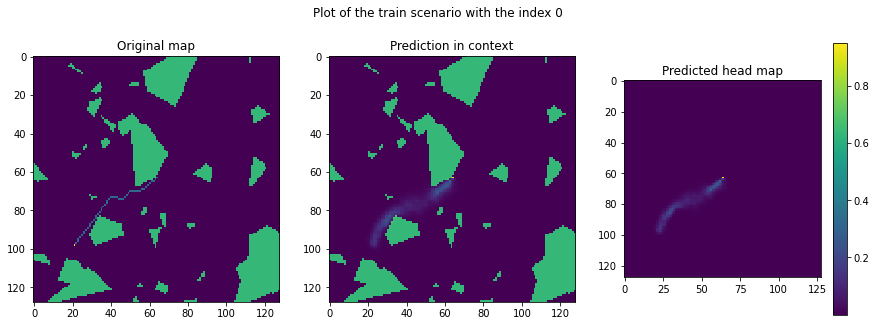

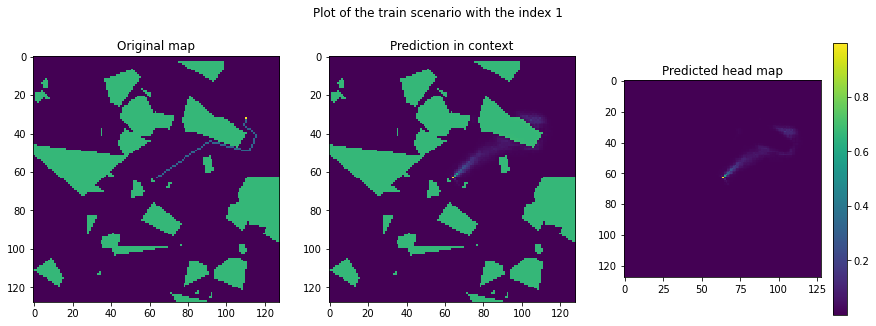

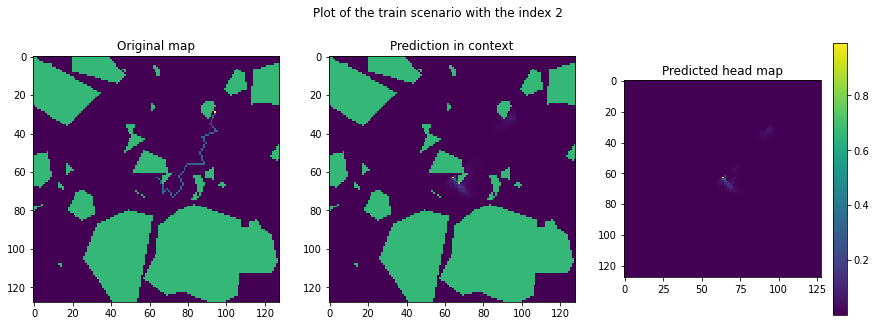

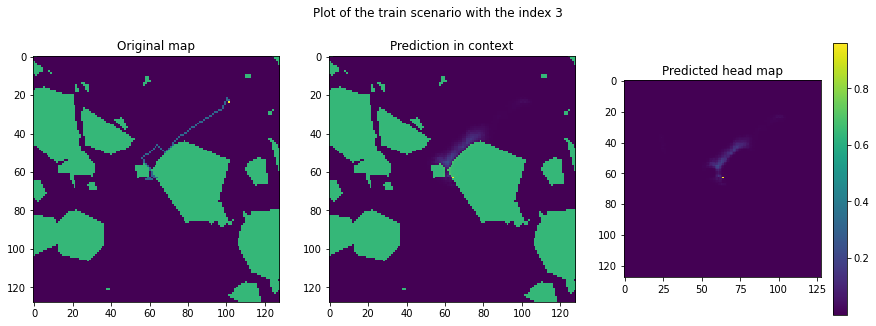

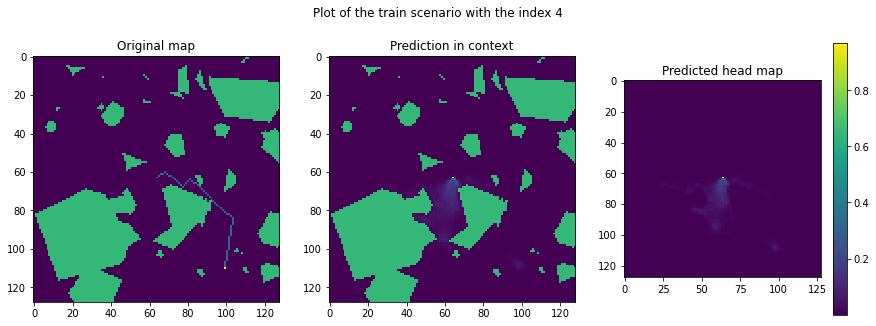

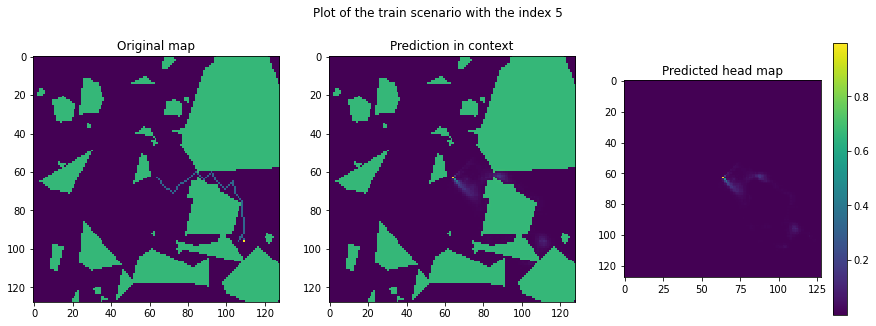

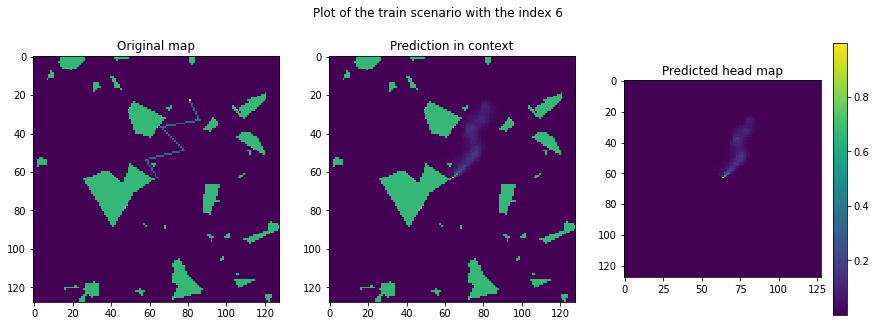

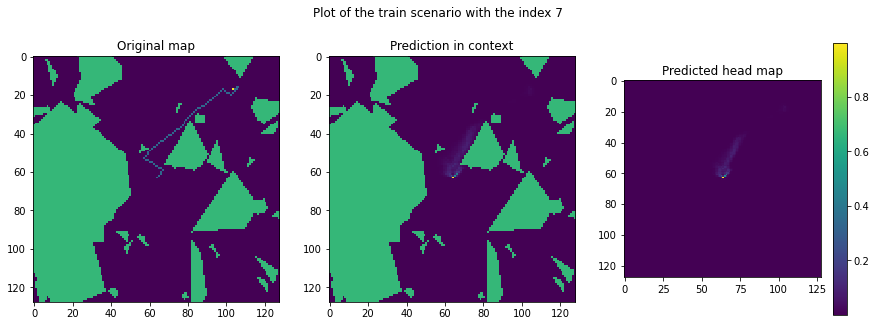

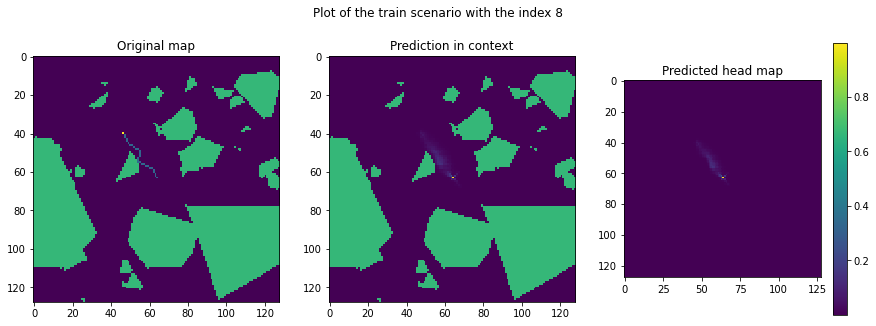

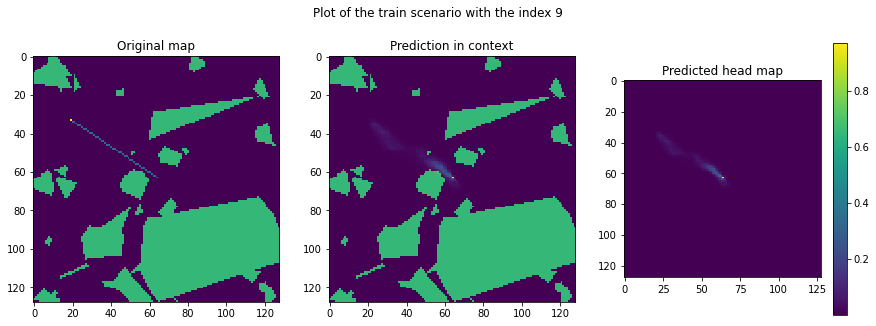

In [54]:
for i in range(10):
    plot_predicted_data(generator, collected_routes, i)

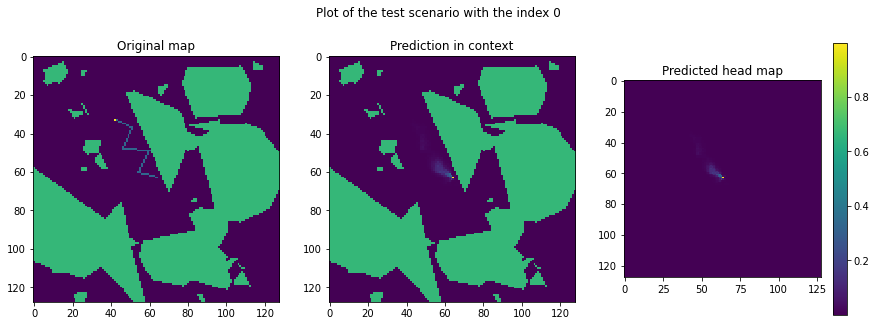

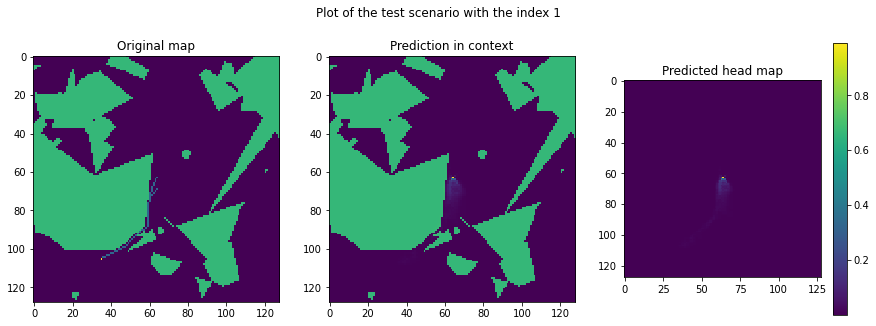

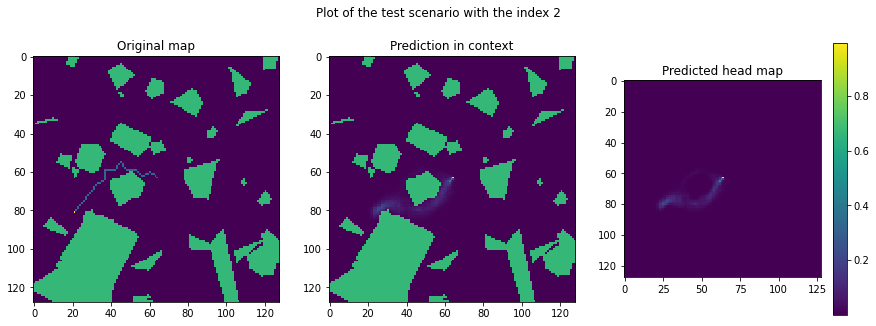

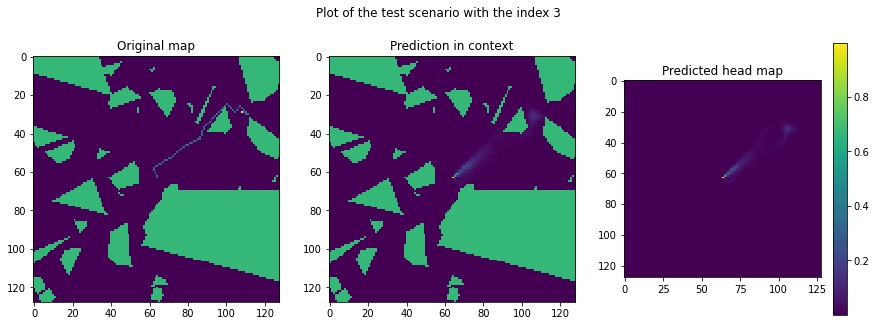

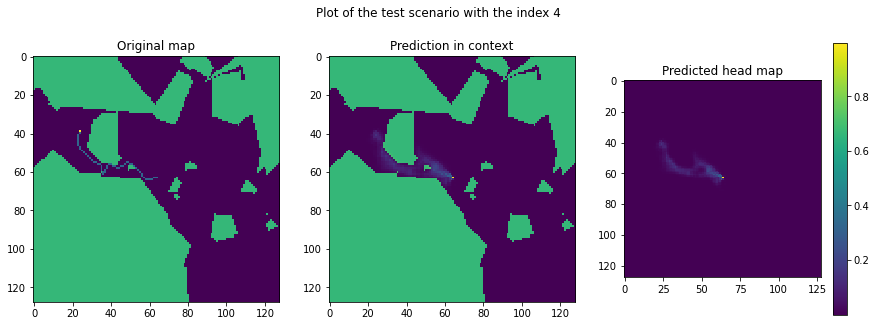

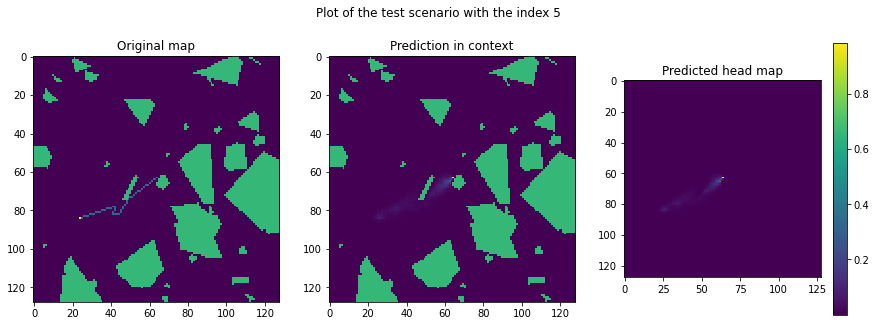

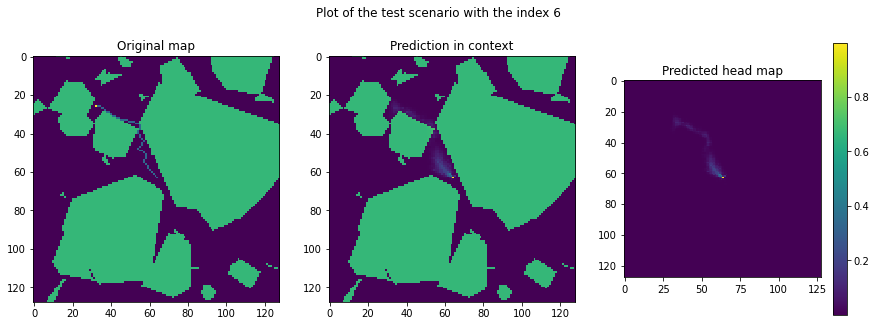

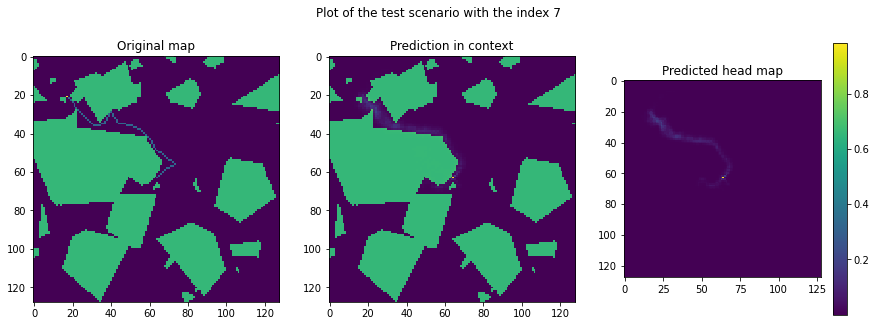

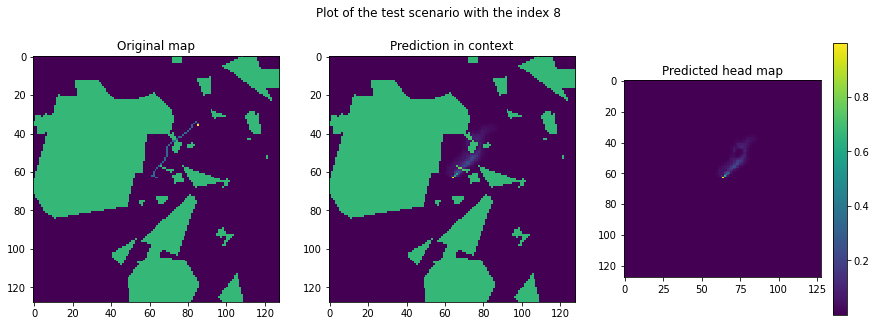

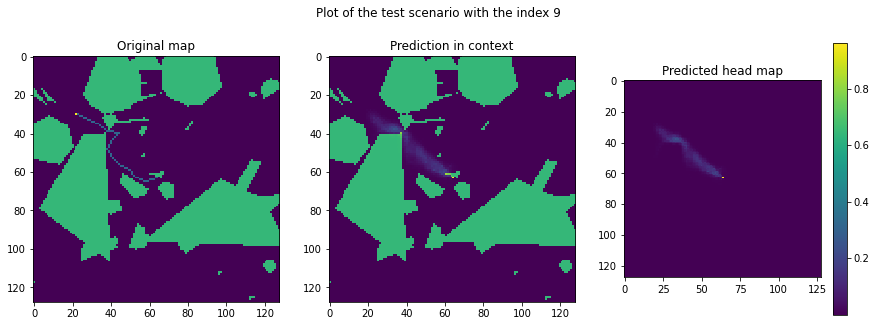

In [55]:
for i in range(10):
    plot_predicted_data(generator, collected_routes, -i - 1)

#### Training mit Routen als Liste von Wendepunkten

Analog wurde das gleiche Model mit einer Liste an Wendepunkten trainiert. Hier wurde mit einem neuen Modell gearbeitet.
Ein Weitertrainieren / Verändern des alten Models wäre vermutlich genauso gut möglich.

In [56]:
del collected_routes
collected_routes = np.load(COLLECTED_ROUTES_DOT_DUMP, allow_pickle=True)
collected_routes.shape

(11883, 128, 128, 3)

#### Betrachtung des trainierten Models mit Routen als Liste von Wendepunkten

Darstellung von Hindernissen, Ziel und Label in der Darstellung der Route als Liste von Wendepunkten.

  0%|          | 0/3 [00:00<?, ?it/s]

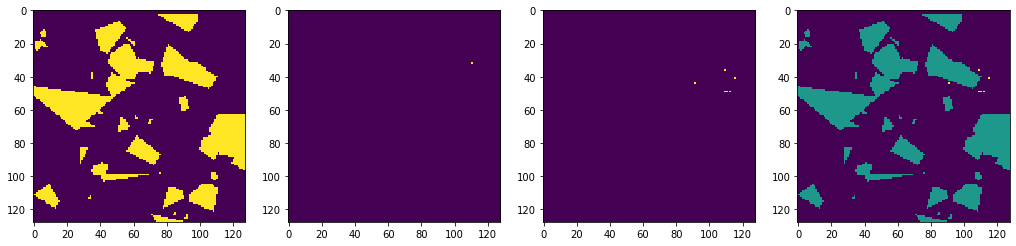

In [57]:
plt.figure(figsize=(17.5, 25))
np_array = np.flip(collected_routes[1, :, :, :], axis=0)

for chanel in tqdm(range(3)):
    plt.subplot(1, 4, chanel + 1)
    plt.imshow(np_array[:, :, chanel], interpolation="nearest")
plt.subplot(1, 4, 4)
plt.imshow(0x88 * np_array[:, :, 0] + 0xFF * np_array[:, :, 2], interpolation="nearest")
plt.show()

In [60]:
# Delete the generator variable if allrady defined. Saves some gpu memory,
if "generator" in globals():
    print("Generator exists. Deleting for reset.")
    del generator

# creates the model
generator = model_generator()

# compiles the model
generator.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=[
        "binary_crossentropy",
        "mean_squared_error",
        "mean_absolute_error",
    ],
)

# starts the training
history = generator.fit(
    collected_routes[:, :, :, :2],
    collected_routes[:, :, :, 2],
    validation_split=0.2,
    epochs=100,
    use_multiprocessing=False,
    workers=1,
    callbacks=[early_stop, tf.keras.callbacks.TerminateOnNaN()],
)

Generator exists. Deleting for reset.
Epoch 1/100
298/298 [==============================] - 157s 521ms/step - loss: 0.1801 - binary_crossentropy: 0.1801 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1524 - val_loss: 0.0286 - val_binary_crossentropy: 0.0286 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0269
Epoch 2/100
298/298 [==============================] - 157s 528ms/step - loss: 0.0059 - binary_crossentropy: 0.0059 - mean_squared_error: 5.0001e-04 - mean_absolute_error: 0.0037 - val_loss: 0.0035 - val_binary_crossentropy: 0.0035 - val_mean_squared_error: 4.7646e-04 - val_mean_absolute_error: 0.0010
Epoch 3/100
298/298 [==============================] - 158s 532ms/step - loss: 0.0034 - binary_crossentropy: 0.0034 - mean_squared_error: 4.7243e-04 - mean_absolute_error: 9.6695e-04 - val_loss: 0.0035 - val_binary_crossentropy: 0.0035 - val_mean_squared_error: 4.7622e-04 - val_mean_absolute_error: 7.2443e-04
Epoch 4/100
298/298 [==============================] 

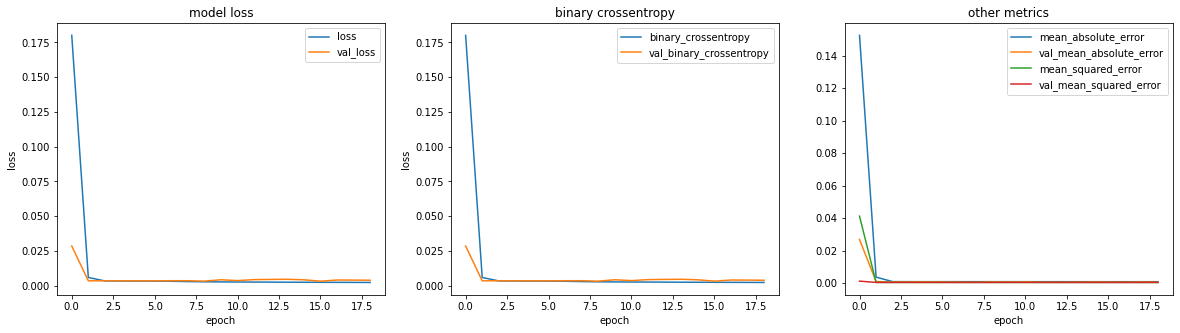

In [63]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plot_history(history.history, "loss")
plt.title("model loss")
plt.subplot(1, 3, 2)
plot_history(history.history, "binary_crossentropy")
plt.title("binary crossentropy")
plt.subplot(1, 3, 3)
plot_history(history.history, ["mean_absolute_error", "mean_squared_error"])
plt.title("other metrics")
plt.show()

Betrachtung des trainierten Models mit Routen als Liste von Kurswechselpositionen.
Die besten Ergebnisse wurden nach 20 Epochen erreicht und lagen bei einer binary_crossentropy von 0.0023 und einer val_binary_crossentropy von 0.0035 bei einer Lernrate von 0.00001. Bei dieser Art von Problem ist jedoch eine Visuelle überprüfung der Prediction notwendig.

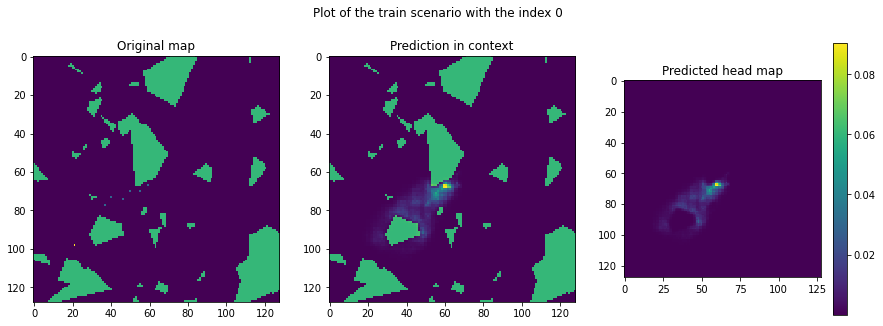

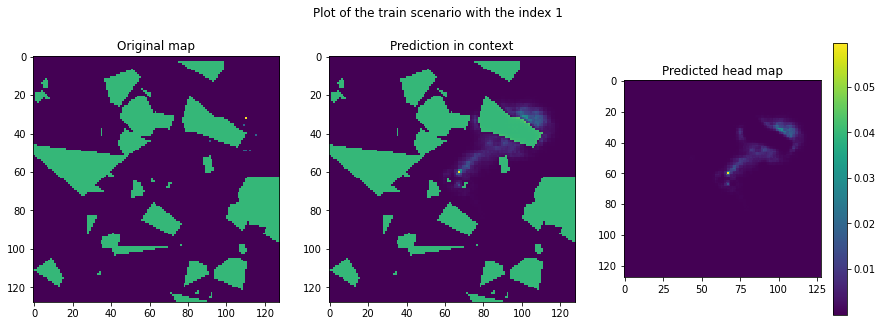

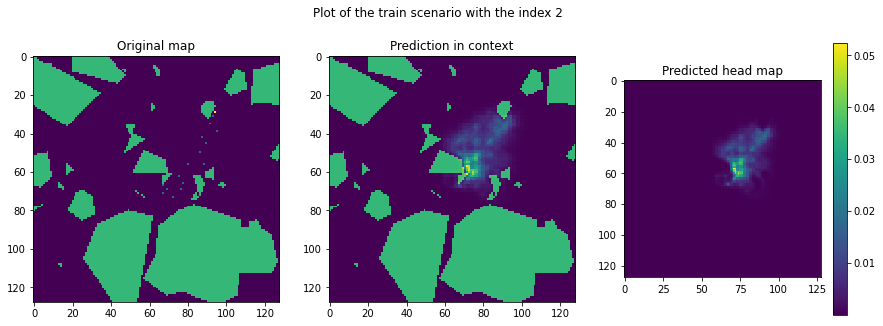

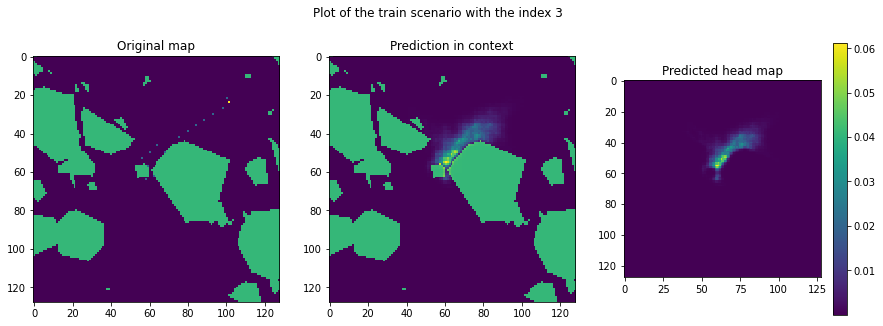

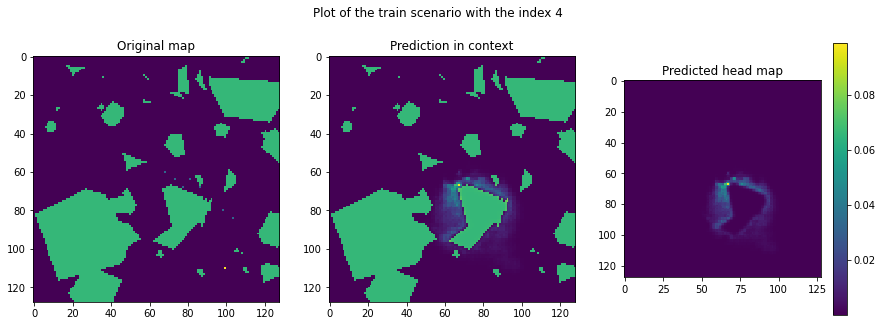

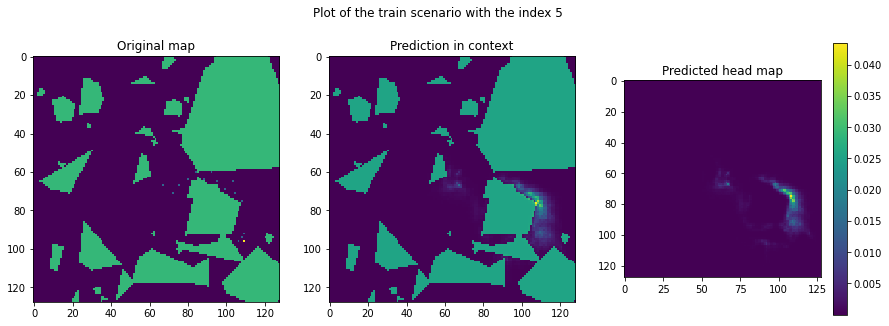

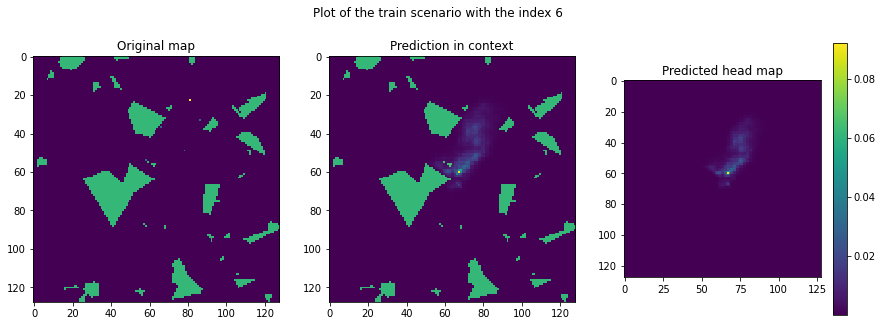

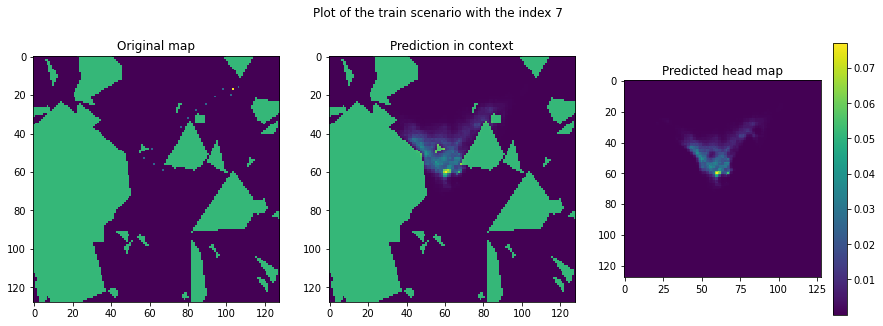

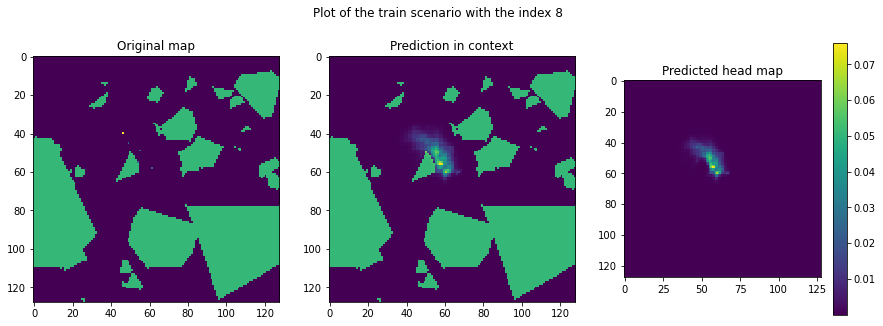

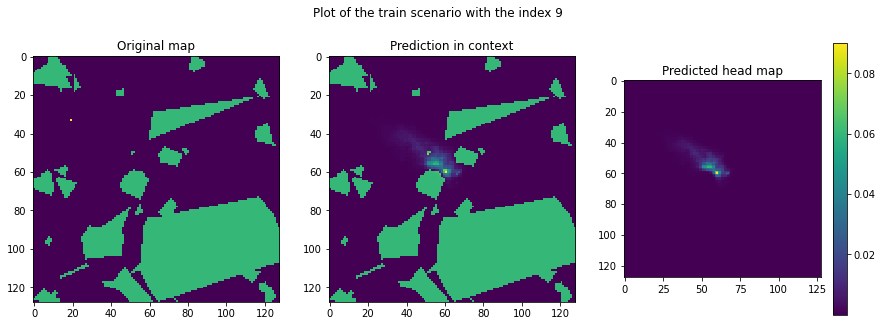

In [64]:
for i in range(10):
    plot_predicted_data(generator, collected_routes, i)

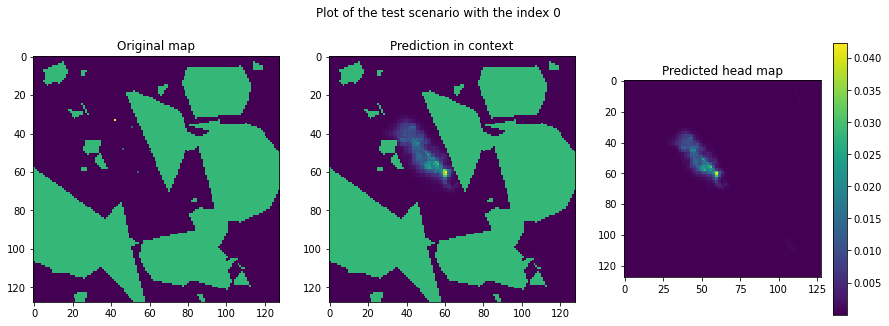

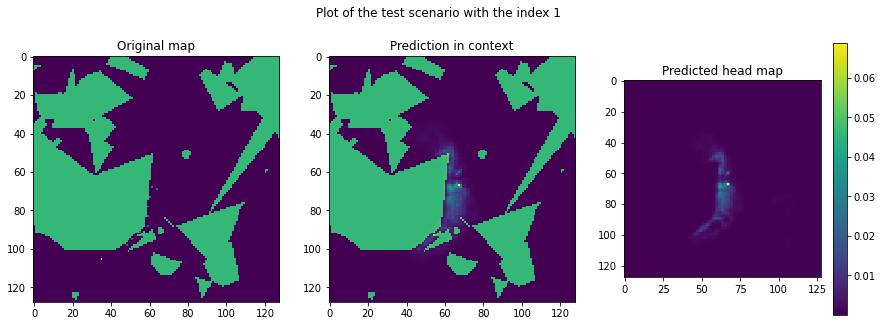

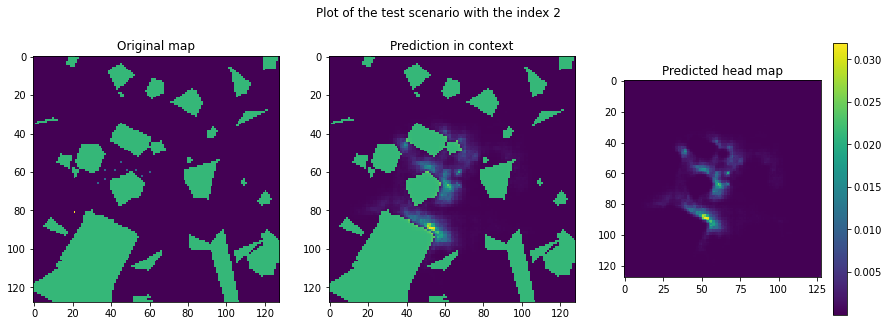

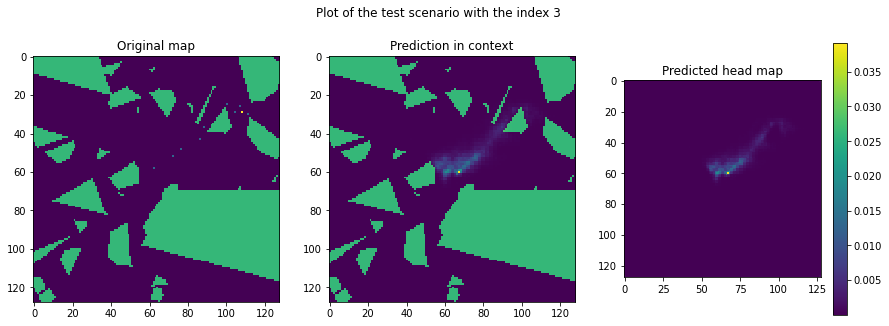

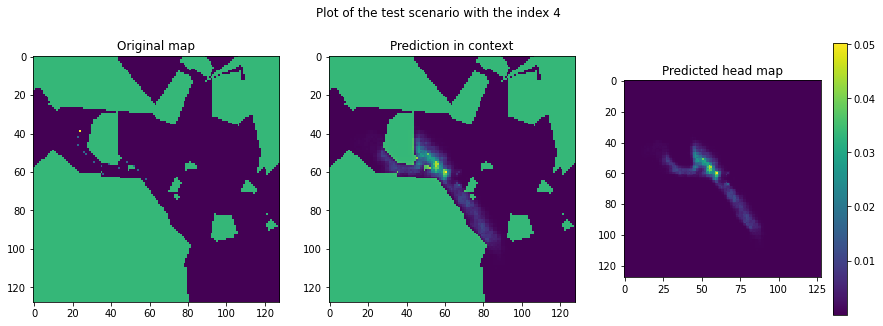

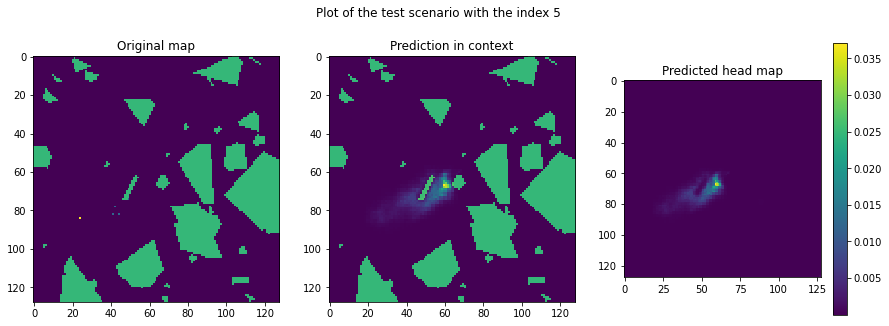

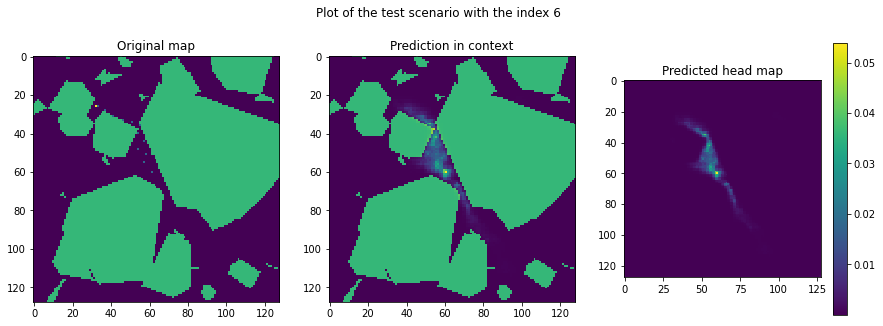

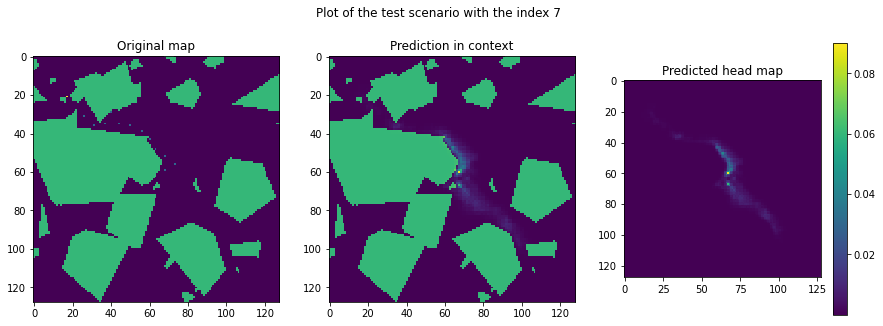

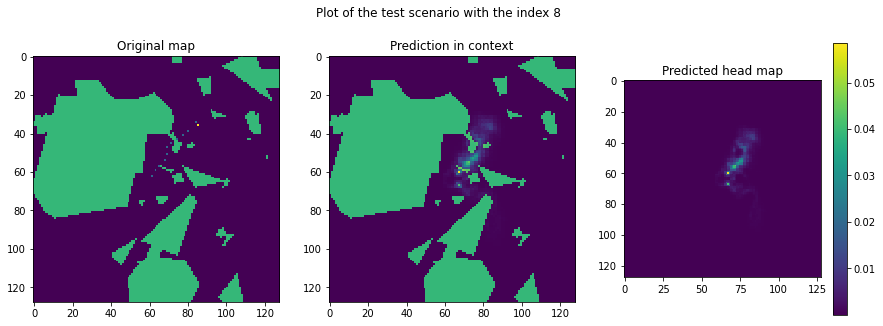

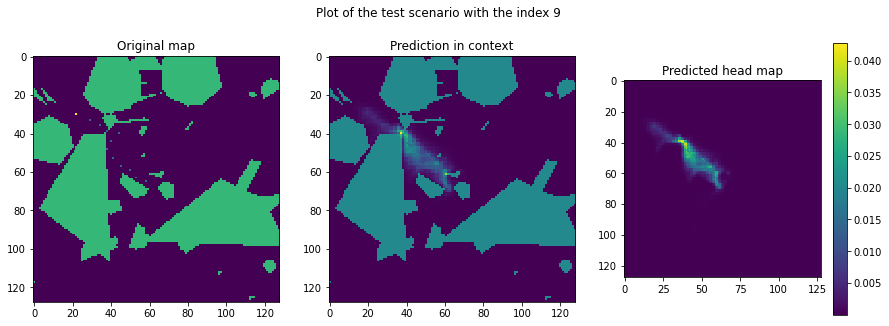

In [65]:
for i in range(10):
    plot_predicted_data(generator, collected_routes, -i - 1)

### Vergleich der Experimente

Wie sehr schnell deutlich wird skalieren, die Ergebnisse der Liniendarstellung viel besser als die Ergebnisse der Punktdarstellung. Der Fehler ist aber bei der Punktdarstellung viel geringer. Dies ist auf die wesentlich mehr Werte, die mit Linien markierten Routen zurückzuführen. Welches der beiden Ergebnisse nachher besser für den Einsatz geeignet ist kann ich nicht sagen. Beide Varianten müssten aber vermutlich neu skaliert werden.
Beide Modelle zeigen aber sowohl bei Trainings als auch Validierungsdaten einen guten Instinkt für die richtige Route.

## Reflektion und Ausblick

Es konnte gezeigt werden, dass das Schätzen einer Segelroute gut funktionieren kann. Es fehlen sicherlich noch viele Faktoren wie lokale Winde, Strömungen und dynamische Hindernisse. Trotzdem bin ich zufrieden mit den Ergebnissen, die in diesem ersten Schritt erzielt werden konnten. Enttäuschend war, wie sehr mich meine eigene GPU limitiert hat. Die Ergebnisse werden sicherlich mit mehr Daten etwas robuster. Die Limits an der Rechenleistung haben leider auch behindert, dass ich mit Werkzeugen wie dem `KerasTuner`, mit dem ich bisher sehr gute Erfahrungen gemacht habe das neuronale Netz noch etwas optimiere und evtl. reduziere, da das `Tensorflow` Beispiel Netz, an dem sich hier orientiert wurde, für ein 3 Kanaliges Bild mit höherer auflösung ausgelegt war. Das Netz wurde darauf zwar angepasst aber nicht auf ein Minimum reduziert. Auch war bedauerlicherweise keine Zeit um sich mit Datenaugmentierung zu beschäftigen. Sonst wäre sicher möglich gewesen einen Random Flip einzuführen der zufällig Label und Situation horizontal spiegelt. In Anbetracht dessen, dass ich aber mehr Daten zur verfügung hatte als genutzt wurden, hätte dies das Ergebnis aber nur unwesentlich verfeinert, auch wenn es zufällige Asymmetrien aus dem Netz genommen hätte. Diese konnten zwar nicht beobachtet werden. Sind aber trotzdem möglich und wahrscheinlich. Auch muss noch geprüft werden, ob die Routenschätzer auch auf einer echten Karte valide Ergebnisse liefern.
Eine Nachbearbeitung des Entweder durch mehr Daten oder durch ein Nachgelagertes verfeinern der Ergebnisse durch ein weiteres Netz oder dass Trainieren mit dem Discriminator des PIX2PIX Papers [3][4], kann zu Verbesserungen führen. Auch kann noch geprüft werden ob die Zielkoordinaten nicht in die Mitte des neuronalen Netzes als abstraktes Feature eingefügt werden können.

Welches der beiden Modelle sich in der Praxis als überlegen erweisen wird und ob die Netze einen Mehrwert bringen können, muss sich erst noch zeigen und kann an dieser Stelle von mir nicht beantwortet werden. Sicher ist dass, die Modelle nicht nur prinzipiell, sondern auch mit dieser Implementierung funktionieren. Die Eingeschränkte zufälligkeit des Zielpunkts bei der Datengenerierung schränkt die allgemeine Anwendbarkeit ein. Nicht aber den Beweis, dass ein solches Netzwerk funktionieren kann.

An dieser Stelle muss ich mich bei den anderen Mitgliedern des Sailing Team Darmstadt e.V. bedanken. Ohne die existierende experimentelle Wegfindung des `Pyrate` Projekts wäre diese Arbeit nicht möglich gewesen.

## Literaturverzeichnis

[1] Jang, Hoyun and Lee, Inwon and Seo, Hyoungseock: *Effectiveness of CFRP rudder aspect ratio for scale model catamaran racing yacht*, 2017

[2] Aurélien Géron: *Praxiseinstig Machinen Learning mit Scikit-Learn, Keras und TensorFlow*, 2020, O.Reilly Verlag

[3] Jun-Yan Zhu: *Image-to-Image Translation with Conditional Adversarial Networks*, 2018, Available: https://arxiv.org/abs/1611.07004

[4] Tensorflow: *pix2pix: Image-to-image translation with a conditional GAN* Available: https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb Commit: df4485e052523e0f852e83cea30ad319808bd97b

[5] Keras: *Keras* Available: https://keras.io/

## Eigenständigkeitserklärung

![](Eigenstaendigkeit.jpg)